## Load Data

In [1]:
import re
from typing import Dict, List, Text, Tuple

import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm import tqdm

import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Input, BatchNormalization
import torch
from torch.utils.data import Dataset, DataLoader

In [6]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']


In [ ]:
train_file = '../data/next_day_wildfire_spread_train*'
validation_file = '../data/next_day_wildfire_spread_eval*'
test_file = '../data/next_day_wildfire_spread_test*'

In [10]:
def normalize_feature(feature, feature_name):
    """ Normalize features except 'PrevFireMask'. """
    if feature_name == 'PrevFireMask':
        return feature
    else:
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):
    """ Parses TFRecord into tensors and normalizes features. """
    feature_description = {feat: tf.io.FixedLenFeature([64, 64], tf.float32) for feat in INPUT_FEATURES + OUTPUT_FEATURES}

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = [normalize_feature(tf.expand_dims(parsed_example[feat], -1), feat) for feat in INPUT_FEATURES]
    inputs = tf.concat(inputs_list, axis=-1)  # Convert to NumPy

    label = tf.expand_dims(parsed_example['FireMask'], -1)  # Shape: [64, 64, 1]
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    return inputs, label

In [11]:
class WildfireDataset(Dataset):
    def __init__(self, tf_dataset):
        self.data = list(tf_dataset.as_numpy_iterator()) # Correctly iterate over the dataset


    def __len__(self):
        """ Return dataset size. """
        return len(self.data)

    def __getitem__(self, idx):
        """ Get a single sample. """
        inputs, label = self.data[idx]
        # inputs = torch.tensor(inputs, dtype=torch.float32)  # Convert to PyTorch tensor
        # label = torch.tensor(label, dtype=torch.float32)
        inputs = torch.tensor(inputs, dtype=torch.float32).permute(2, 0, 1)  # [H, W, C] → [C, H, W]
        label = torch.tensor(label, dtype=torch.float32).permute(2, 0, 1)       # [H, W, 1] → [1, H, W] if needed

        return inputs, label


In [12]:
def get_tensorflow_dataset(file_pattern):
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Convert train, validation, and test datasets
train_numpy = get_tensorflow_dataset(train_file)
val_numpy = get_tensorflow_dataset(validation_file)
test_numpy = get_tensorflow_dataset(test_file)

# Create PyTorch datasets
train_dataset = WildfireDataset(train_numpy)
val_dataset = WildfireDataset(val_numpy)
test_dataset = WildfireDataset(test_numpy)

I0000 00:00:1745333704.954020      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745333704.954758      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Example batch
for inputs, labels in test_loader:
    print(inputs.shape, labels.shape)  # Expected: [batch_size, 64, 64, num_features], [batch_size, 64, 64, 1]
    break

torch.Size([32, 12, 64, 64]) torch.Size([32, 1, 64, 64])


## CNN-based encoder decoder

#### Simple Unet Implementation

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, in_c, out_c, is_res = False, kernel_size=3, padding=1):
    super(ResBlock, self).__init__()
    self.same_c = in_c == out_c
    self.is_res = is_res
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size, padding=padding),
        nn.BatchNorm2d(out_c),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_c, out_c, kernel_size, padding=padding),
        nn.BatchNorm2d(out_c),
        nn.ReLU()
    )

  def forward(self,x):
    x1 = self.conv1(x)
    x2 = self.conv2(x1)
    if self.is_res:
      if self.same_c:
        out = x + x2
      else:
        out = x1 + x2
    else:
      out = x2
    return out



In [ ]:
class ResBlock2(nn.Module):
  def __init__(self, in_c, out_c, downsample='conv', dropout= 0.1,is_res = False, kernel_size=3, padding=1):
    super(ResBlock2, self).__init__()
    self.same_c = in_c == out_c
    self.is_res = is_res
    self.in_c = in_c
    self.out_c = out_c

    layers = [
        nn.LeakyReLU(),
        nn.Dropout2d(dropout)
        ]
    if downsample == 'conv':
      layers.append(nn.Conv2d(in_c, out_c, kernel_size, padding=padding))
    else:
      layers.append(
          nn.MaxPool2d(2)
          )
      if self.in_c != self.out_c:
        layers.append(nn.Conv2d(in_c, out_c, 1))
    layers.extend([
        nn.LeakyReLU(),
        nn.Dropout2d(dropout),
        nn.Conv2d(out_c, out_c, kernel_size, padding=padding),
        nn.Dropout2d(dropout)
    ])
    self.net = nn.Sequential(*layers)
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=1),
        nn.Dropout(dropout)
    ) if is_res else nn.Identity()

  def forward(self,x):
    #print(f"ResBlock2 input shape: {x.shape}")
    x1 = self.net(x)
    x2 = self.shortcut(x) if self.is_res else 0
    out = x1 + x2
    return out




In [ ]:
class SimpleUNet(nn.Module):
  def __init__(self, in_c, encoder_dims, decoder_dims,out_c=1):
    super(SimpleUNet, self).__init__()

    self.in_c = in_c
    self.encoder_dims = encoder_dims
    self.decoder_dims = decoder_dims
    self.out_c = out_c

    self.input_conv = nn.Sequential(
            nn.Conv2d(in_c, encoder_dims[0], kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(encoder_dims[0], encoder_dims[0], kernel_size=3, padding=1),
            nn.Dropout2d(dropout)
        )
    self.input_shortcut = nn.Sequential(
        nn.Conv2d(in_c, encoder_dims[0], kernel_size=1, padding=1),
        nn.Dropout2d(dropout)
    )
    self.down_blocks = nn.ModuleList()
    for i in range(len(encoder_dims) - 1):
      self.down_blocks.append(ResBlock2(encoder_dims[i], encoder_dims[i+1],downsample='maxpool', dropout=dropout))
      #print("down_block", i, ":",encoder_dims[i+1],",", encoder_dims[i+1])
    self.bottleneck = ResBlock2(encoder_dims[-1], encoder_dims[-1], is_res=True)

    self.up_blocks = nn.ModuleList()
    for i in range(len(decoder_dims[:-1])):
      skip_c = encoder_dims[-(i + 1)]
      up_c = decoder_dims[i]
      mid_c = decoder_dims[i+1]
      #in_c = decoder_dims[i]
      #out_c = decoder_dims[i + 1]
      self.up_blocks.append(
          nn.Sequential(
              nn.ConvTranspose2d(skip_c+up_c, mid_c, kernel_size=2, stride=2),
              nn.BatchNorm2d(mid_c),
              nn.LeakyReLU(),
              ResBlock2(mid_c, mid_c, downsample='conv')
          )
      )
      #print("up_block", i,":", skip_c+up_c,",", mid_c, "skip_c", skip_c)
    self.output_conv = nn.Conv2d(decoder_dims[-1], self.out_c, kernel_size=1)

  def forward(self,x):
    x = self.input_conv(x)
    skip_connections = []
    for down_block in self.down_blocks:
      #print(f"[DownBlock] x.shape: {x.shape}, expects in_c={down_block.in_c}, out_c={down_block.out_c}")
      x = down_block(x)
      skip_connections.append(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]
    for i in range(len(self.up_blocks)):
      #print(f"[UpBlock {i}] skip: {skip_connections[i].shape}, x before: {x.shape}")
      x = torch.cat((skip_connections[i], x), dim=1)
      #print(f"up_block {i} input shape: {x.shape}")
      x = self.up_blocks[i](x)

    x = self.output_conv(x)
    return x


In [ ]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=10, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss and optimizer
    #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))
    criterion = criterion.to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{epochs}] Training"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        dice_score = 0.0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{epochs}] Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                #dice_score += dice_coefficient(outputs, targets).item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        #avg_dice = dice_score / len(val_loader.dataset)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              )


In [15]:
lr = 0.0001
pos_weight = 3.0
num_epochs = 100
dropout = 0.1
encoder_dims = [16,16,32]
decoder_dims = [32,16,16]

In [ ]:
model = SimpleUNet(in_c=12, encoder_dims=encoder_dims, decoder_dims=decoder_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

In [ ]:
train_model(model, optimizer, criterion, train_loader, val_loader, epochs=num_epochs)

[Epoch 1/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.40it/s]


Epoch [1/100] Train Loss: 0.0862 Val Loss: 0.1170 


[Epoch 2/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.10it/s]


Epoch [2/100] Train Loss: 0.0858 Val Loss: 0.1166 


[Epoch 3/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.11it/s]


Epoch [3/100] Train Loss: 0.0855 Val Loss: 0.1148 


[Epoch 4/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.26it/s]


Epoch [4/100] Train Loss: 0.0854 Val Loss: 0.1155 


[Epoch 5/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.59it/s]


Epoch [5/100] Train Loss: 0.0848 Val Loss: 0.1166 


[Epoch 6/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.01it/s]


Epoch [6/100] Train Loss: 0.0847 Val Loss: 0.1168 


[Epoch 7/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.65it/s]


Epoch [7/100] Train Loss: 0.0845 Val Loss: 0.1159 


[Epoch 8/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.78it/s]


Epoch [8/100] Train Loss: 0.0841 Val Loss: 0.1157 


[Epoch 9/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 89.09it/s]


Epoch [9/100] Train Loss: 0.0839 Val Loss: 0.1161 


[Epoch 10/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.09it/s]


Epoch [10/100] Train Loss: 0.0838 Val Loss: 0.1145 


[Epoch 11/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.13it/s]


Epoch [11/100] Train Loss: 0.0840 Val Loss: 0.1153 


[Epoch 12/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.29it/s]


Epoch [12/100] Train Loss: 0.0836 Val Loss: 0.1157 


[Epoch 13/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 96.80it/s]


Epoch [13/100] Train Loss: 0.0832 Val Loss: 0.1148 


[Epoch 14/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.97it/s]


Epoch [14/100] Train Loss: 0.0831 Val Loss: 0.1149 


[Epoch 15/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.12it/s]


Epoch [15/100] Train Loss: 0.0832 Val Loss: 0.1157 


[Epoch 16/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.33it/s]


Epoch [16/100] Train Loss: 0.0828 Val Loss: 0.1151 


[Epoch 17/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 97.51it/s]


Epoch [17/100] Train Loss: 0.0828 Val Loss: 0.1152 


[Epoch 18/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.43it/s]


Epoch [18/100] Train Loss: 0.0823 Val Loss: 0.1142 


[Epoch 19/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.43it/s]


Epoch [19/100] Train Loss: 0.0820 Val Loss: 0.1138 


[Epoch 20/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 85.74it/s]


Epoch [20/100] Train Loss: 0.0820 Val Loss: 0.1133 


[Epoch 21/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.20it/s]


Epoch [21/100] Train Loss: 0.0817 Val Loss: 0.1135 


[Epoch 22/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.27it/s]


Epoch [22/100] Train Loss: 0.0814 Val Loss: 0.1139 


[Epoch 23/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.09it/s]


Epoch [23/100] Train Loss: 0.0818 Val Loss: 0.1135 


[Epoch 24/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 90.86it/s]


Epoch [24/100] Train Loss: 0.0816 Val Loss: 0.1133 


[Epoch 25/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.21it/s]


Epoch [25/100] Train Loss: 0.0810 Val Loss: 0.1133 


[Epoch 26/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.92it/s]


Epoch [26/100] Train Loss: 0.0812 Val Loss: 0.1139 


[Epoch 27/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.54it/s]


Epoch [27/100] Train Loss: 0.0809 Val Loss: 0.1123 


[Epoch 28/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 95.53it/s]


Epoch [28/100] Train Loss: 0.0811 Val Loss: 0.1136 


[Epoch 29/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.86it/s]


Epoch [29/100] Train Loss: 0.0809 Val Loss: 0.1126 


[Epoch 30/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.55it/s]


Epoch [30/100] Train Loss: 0.0808 Val Loss: 0.1128 


[Epoch 31/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.49it/s]


Epoch [31/100] Train Loss: 0.0806 Val Loss: 0.1128 


[Epoch 32/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.19it/s]


Epoch [32/100] Train Loss: 0.0809 Val Loss: 0.1132 


[Epoch 33/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.94it/s]


Epoch [33/100] Train Loss: 0.0804 Val Loss: 0.1135 


[Epoch 34/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.23it/s]


Epoch [34/100] Train Loss: 0.0803 Val Loss: 0.1129 


[Epoch 35/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 93.10it/s]


Epoch [35/100] Train Loss: 0.0803 Val Loss: 0.1126 


[Epoch 36/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.01it/s]


Epoch [36/100] Train Loss: 0.0802 Val Loss: 0.1120 


[Epoch 37/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.71it/s]


Epoch [37/100] Train Loss: 0.0799 Val Loss: 0.1129 


[Epoch 38/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.07it/s]


Epoch [38/100] Train Loss: 0.0800 Val Loss: 0.1122 


[Epoch 39/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 95.97it/s]


Epoch [39/100] Train Loss: 0.0798 Val Loss: 0.1130 


[Epoch 40/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.18it/s]


Epoch [40/100] Train Loss: 0.0797 Val Loss: 0.1128 


[Epoch 41/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.72it/s]


Epoch [41/100] Train Loss: 0.0796 Val Loss: 0.1123 


[Epoch 42/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.18it/s]


Epoch [42/100] Train Loss: 0.0796 Val Loss: 0.1121 


[Epoch 43/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.74it/s]


Epoch [43/100] Train Loss: 0.0796 Val Loss: 0.1124 


[Epoch 44/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.39it/s]


Epoch [44/100] Train Loss: 0.0796 Val Loss: 0.1121 


[Epoch 45/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.50it/s]


Epoch [45/100] Train Loss: 0.0795 Val Loss: 0.1127 


[Epoch 46/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 92.62it/s]


Epoch [46/100] Train Loss: 0.0792 Val Loss: 0.1122 


[Epoch 47/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.92it/s]


Epoch [47/100] Train Loss: 0.0792 Val Loss: 0.1126 


[Epoch 48/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.99it/s]


Epoch [48/100] Train Loss: 0.0791 Val Loss: 0.1122 


[Epoch 49/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.81it/s]


Epoch [49/100] Train Loss: 0.0794 Val Loss: 0.1118 


[Epoch 50/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 98.09it/s] 


Epoch [50/100] Train Loss: 0.0793 Val Loss: 0.1126 


[Epoch 51/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.36it/s]


Epoch [51/100] Train Loss: 0.0794 Val Loss: 0.1121 


[Epoch 52/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.42it/s]


Epoch [52/100] Train Loss: 0.0789 Val Loss: 0.1127 


[Epoch 53/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.81it/s]


Epoch [53/100] Train Loss: 0.0790 Val Loss: 0.1126 


[Epoch 54/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.38it/s]


Epoch [54/100] Train Loss: 0.0789 Val Loss: 0.1125 


[Epoch 55/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.57it/s]


Epoch [55/100] Train Loss: 0.0790 Val Loss: 0.1129 


[Epoch 56/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.29it/s]


Epoch [56/100] Train Loss: 0.0791 Val Loss: 0.1120 


[Epoch 57/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 81.81it/s]


Epoch [57/100] Train Loss: 0.0787 Val Loss: 0.1122 


[Epoch 58/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 97.30it/s]


Epoch [58/100] Train Loss: 0.0788 Val Loss: 0.1131 


[Epoch 59/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.07it/s]


Epoch [59/100] Train Loss: 0.0786 Val Loss: 0.1136 


[Epoch 60/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.01it/s]


Epoch [60/100] Train Loss: 0.0786 Val Loss: 0.1115 


[Epoch 61/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 84.49it/s]


Epoch [61/100] Train Loss: 0.0786 Val Loss: 0.1121 


[Epoch 62/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.12it/s]


Epoch [62/100] Train Loss: 0.0788 Val Loss: 0.1122 


[Epoch 63/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.20it/s]


Epoch [63/100] Train Loss: 0.0784 Val Loss: 0.1124 


[Epoch 64/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.92it/s]


Epoch [64/100] Train Loss: 0.0783 Val Loss: 0.1120 


[Epoch 65/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 89.22it/s]


Epoch [65/100] Train Loss: 0.0780 Val Loss: 0.1119 


[Epoch 66/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.31it/s]


Epoch [66/100] Train Loss: 0.0779 Val Loss: 0.1115 


[Epoch 67/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.96it/s]


Epoch [67/100] Train Loss: 0.0783 Val Loss: 0.1131 


[Epoch 68/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.04it/s]


Epoch [68/100] Train Loss: 0.0782 Val Loss: 0.1118 


[Epoch 69/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 93.44it/s]


Epoch [69/100] Train Loss: 0.0778 Val Loss: 0.1119 


[Epoch 70/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.31it/s]


Epoch [70/100] Train Loss: 0.0781 Val Loss: 0.1113 


[Epoch 71/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.52it/s]


Epoch [71/100] Train Loss: 0.0780 Val Loss: 0.1123 


[Epoch 72/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.65it/s]


Epoch [72/100] Train Loss: 0.0779 Val Loss: 0.1116 


[Epoch 73/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 94.60it/s]


Epoch [73/100] Train Loss: 0.0778 Val Loss: 0.1126 


[Epoch 74/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.44it/s]


Epoch [74/100] Train Loss: 0.0778 Val Loss: 0.1120 


[Epoch 75/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.55it/s]


Epoch [75/100] Train Loss: 0.0781 Val Loss: 0.1124 


[Epoch 76/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 97.09it/s] 


Epoch [76/100] Train Loss: 0.0779 Val Loss: 0.1126 


[Epoch 77/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.56it/s]


Epoch [77/100] Train Loss: 0.0777 Val Loss: 0.1115 


[Epoch 78/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.08it/s]


Epoch [78/100] Train Loss: 0.0774 Val Loss: 0.1117 


[Epoch 79/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.01it/s]


Epoch [79/100] Train Loss: 0.0778 Val Loss: 0.1119 


[Epoch 80/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 99.52it/s] 


Epoch [80/100] Train Loss: 0.0777 Val Loss: 0.1122 


[Epoch 81/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.51it/s]


Epoch [81/100] Train Loss: 0.0776 Val Loss: 0.1114 


[Epoch 82/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.43it/s]


Epoch [82/100] Train Loss: 0.0774 Val Loss: 0.1115 


[Epoch 83/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.45it/s]


Epoch [83/100] Train Loss: 0.0775 Val Loss: 0.1126 


[Epoch 84/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 90.97it/s]


Epoch [84/100] Train Loss: 0.0776 Val Loss: 0.1116 


[Epoch 85/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.63it/s]


Epoch [85/100] Train Loss: 0.0774 Val Loss: 0.1112 


[Epoch 86/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.32it/s]


Epoch [86/100] Train Loss: 0.0774 Val Loss: 0.1116 


[Epoch 87/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 96.07it/s]


Epoch [87/100] Train Loss: 0.0771 Val Loss: 0.1114 


[Epoch 88/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.70it/s]


Epoch [88/100] Train Loss: 0.0771 Val Loss: 0.1112 


[Epoch 89/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.17it/s]


Epoch [89/100] Train Loss: 0.0772 Val Loss: 0.1114 


[Epoch 90/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.61it/s]


Epoch [90/100] Train Loss: 0.0772 Val Loss: 0.1122 


[Epoch 91/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 95.99it/s]


Epoch [91/100] Train Loss: 0.0768 Val Loss: 0.1118 


[Epoch 92/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.25it/s]


Epoch [92/100] Train Loss: 0.0768 Val Loss: 0.1110 


[Epoch 93/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.52it/s]


Epoch [93/100] Train Loss: 0.0770 Val Loss: 0.1117 


[Epoch 94/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.53it/s]


Epoch [94/100] Train Loss: 0.0769 Val Loss: 0.1121 


[Epoch 95/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 89.41it/s]


Epoch [95/100] Train Loss: 0.0769 Val Loss: 0.1121 


[Epoch 96/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.73it/s]


Epoch [96/100] Train Loss: 0.0767 Val Loss: 0.1115 


[Epoch 97/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.58it/s]


Epoch [97/100] Train Loss: 0.0764 Val Loss: 0.1114 


[Epoch 98/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.73it/s]


Epoch [98/100] Train Loss: 0.0766 Val Loss: 0.1113 


[Epoch 99/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.42it/s]


Epoch [99/100] Train Loss: 0.0766 Val Loss: 0.1123 


[Epoch 100/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.79it/s]

Epoch [100/100] Train Loss: 0.0765 Val Loss: 0.1117 


## AutoEncoder

#### Each resnet block has at most 2 conv2d blocks

In [41]:
class ResBlock3(nn.Module):
  def __init__(self, in_c, mid_c, out_c,
               dropout= 0.1, batch_norm=True, pool_size=2,
               kernel_size=3, strides=(1,1), padding=1):
    super(ResBlock3, self).__init__()

    self.same_c = in_c == out_c
    self.in_c = in_c
    self.mid_c = mid_c
    self.out_c = out_c
    layers = []
    if batch_norm:
      layers.append(nn.BatchNorm2d(in_c))

      layers.extend([
        nn.LeakyReLU(),
        nn.Dropout2d(dropout)
        ]
    )

    if strides[0] ==1:
      # by default, no downsampling needed. and the stride normally is 1
      layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size,
                              padding=padding, stride=strides[0]))
    else:
      layers.append(
          nn.MaxPool2d(pool_size, strides[0])
          )
      if self.in_c != self.mid_c:
        layers.append(nn.Conv2d(in_c, mid_c, kernel_size=1))

    if batch_norm:
       layers.append(nn.BatchNorm2d(mid_c))

    layers.extend([
        nn.LeakyReLU(),
        nn.Dropout2d(dropout),
        nn.Conv2d(mid_c, out_c, kernel_size=kernel_size, stride=strides[1],
                  padding=padding),
        nn.Dropout2d(dropout)
    ])
    self.net = nn.Sequential(*layers)

    self.shortcut = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=1,padding=0,stride=strides[0]),
        nn.BatchNorm2d(out_c) if batch_norm else nn.Identity(),
        nn.Dropout(dropout)
    )


  def forward(self,x):
    #print(f"ResBlock3 input shape: {x.shape}")
    x1 = self.net(x)
    x2 = self.shortcut(x)
    out = x1 + x2
    return out


#### The encoder decoder model

In [42]:
class Autoencoder(nn.Module):
  def __init__(self,
               in_channels, out_channels,
               encoder_layers, encoder_pools,
               decoder_layers, decoder_pools,
               dropout=0.1, batch_norm=True,
               ):
    super(Autoencoder, self).__init__()

    self.in_channels = in_channels
    self.out_channels = out_channels
    self.encoder_layers = encoder_layers
    self.decoder_layers = decoder_layers
    self.encoder_pools = encoder_pools
    self.decoder_pools = decoder_pools
    self.dropout = dropout
    self.batch_norm = batch_norm

    self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels, encoder_layers[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(encoder_layers[0]) if batch_norm else nn.Identity(),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(encoder_layers[0], encoder_layers[0], kernel_size=3, padding=1),
            nn.Dropout2d(dropout)
        )
    self.input_shortcut = nn.Sequential(
        nn.Conv2d(in_channels, encoder_layers[0], kernel_size=1, padding=0),
        nn.BatchNorm2d(encoder_layers[0]) if batch_norm else nn.Identity(),
        nn.Dropout2d(dropout)
    )

    self.encoder_blocks = nn.ModuleList()
    for i in range(len(encoder_layers) - 1):
      self.encoder_blocks.append(
          ResBlock3(encoder_layers[i], encoder_layers[i+1],encoder_layers[i+1],
                    dropout=dropout, batch_norm=batch_norm,
                    pool_size=encoder_pools[i+1],
                    strides=(encoder_pools[i+1],1)
          )
      )

    self.bottleneck = ResBlock3(
       in_c=encoder_layers[-1],
       mid_c=encoder_layers[-1],
       out_c=encoder_layers[-1],
       dropout=dropout,
       batch_norm=batch_norm
    )


    self.decoder_blocks = nn.ModuleList()
    for i in range(len(decoder_layers)):
      self.decoder_blocks.append(
          nn.Sequential(
              nn.Upsample(scale_factor=decoder_pools[i], mode='nearest'),
              ResBlock3(
                  in_c = encoder_layers[-1] if i==0 else decoder_layers[i-1],
                  mid_c= decoder_layers[i], out_c=decoder_layers[i],
                  dropout=dropout, batch_norm=batch_norm
                  )
          )
      )

    # Output convolution (explicitly using out_channels)
    self.output_conv = nn.Conv2d(decoder_layers[-1],
                                 self.out_channels, kernel_size=1)

  def forward(self,x):
    x1 = self.input_conv(x)
    shortcut = self.input_shortcut(x)

    x2 = x1 + shortcut
    for encoder_block in self.encoder_blocks:
      x2 = encoder_block(x2)

    x2 = self.bottleneck(x2)

    for decoder_block in self.decoder_blocks:
      x2 = decoder_block(x2)

    x2 = self.output_conv(x2)
    return x2


#### Model parameters

In [43]:
params_config = {
    'in_channels': 12,
    'out_channels': 1,
    'encoder_layers': [16, 16, 32],
    'decoder_layers': [32, 16],
    'encoder_pools': [1, 2, 2],
    'decoder_pools': [2, 2],
    'dropout': 0.1,
    'batch_norm': True
}

In [ ]:
model1 = Autoencoder(**params_config)
#print(model1)

## Metrics: AUC(PR), Precision, Recall

In [18]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
import numpy as np

In [19]:
def evaluate_model_metrics(model, data_loader, threshold=0.5, device=None):
    """
    Evaluate model using multiple metrics: AUC PR, Precision, Recall, and F1-score.

    Args:
        model: The trained model to evaluate
        data_loader: Data loader for evaluation
        threshold: Classification threshold (default 0.5)
        device: Device to use for evaluation

    Returns:
        metrics: Dictionary containing AUC PR, precision, recall, and F1-score
    """

    model.eval()

    all_targets = []
    all_predictions = []
    all_binary_predictions = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Apply sigmoid to convert logits to probabilities
            probs = torch.sigmoid(outputs)

            # Binary predictions using threshold
            binary_preds = (probs > threshold).float()

            # Collect all predictions and targets
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(probs.cpu().numpy())
            all_binary_predictions.append(binary_preds.cpu().numpy())

    # Concatenate all batches
    all_targets = np.concatenate(all_targets).flatten()
    all_predictions = np.concatenate(all_predictions).flatten()
    all_binary_predictions = np.concatenate(all_binary_predictions).flatten()

    # Calculate metrics
    auc_pr = average_precision_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_binary_predictions, zero_division=0)
    recall = recall_score(all_targets, all_binary_predictions, zero_division=0)
    f1 = f1_score(all_targets, all_binary_predictions, zero_division=0)

    metrics = {
        'auc_pr': auc_pr,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

## Training model

In [45]:
lr = 0.0001
pos_weight = 3.0
num_epochs = 100

In [46]:
def train_model(model, train_loader, val_loader, lr=0.001,pos_weight=3.0, num_epochs=10, device=None):
    """Train the wildfire segmentation model with comprehensive metrics."""
    # Set device
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss function
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([pos_weight], device=device)
    )

    # Optimizer
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_reg_loss': [],
        'val_reg_loss': [],
        'val_auc_pr': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1_score': []
    }

    # Best model tracking
    best_auc_pr = 0
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_reg_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate losses
            bce_loss = criterion(outputs, targets)
            #reg_loss = model.get_regularization_loss()
            #total_loss = bce_loss + reg_loss
            total_loss = bce_loss

            total_loss.backward()
            optimizer.step()

            train_loss += bce_loss.item() * inputs.size(0)
            #train_reg_loss += reg_loss.item() * inputs.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        #avg_train_reg_loss = train_reg_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_train_loss)
        #history['train_reg_loss'].append(avg_train_reg_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        #val_reg_loss = 0.0

        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                # Calculate losses
                bce_loss = criterion(outputs, targets)
                #reg_loss = model.get_regularization_loss()

                val_loss += bce_loss.item() * inputs.size(0)
                #val_reg_loss += reg_loss.item() * inputs.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        #avg_val_reg_loss = val_reg_loss / len(val_loader.dataset)
        history['val_loss'].append(avg_val_loss)
        #history['val_reg_loss'].append(avg_val_reg_loss)

        # Calculate metrics
        metrics = evaluate_model_metrics(model, val_loader, device=device)

        # Store metrics in history
        for metric_name, metric_value in metrics.items():
            history[f'val_{metric_name}'].append(metric_value)

        # Save best model based on AUC PR
        auc_pr = metrics['auc_pr']
        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_model_state = model.state_dict().copy()
            print(f"New best model with AUC PR: {best_auc_pr:.4f}")

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} "
              f"Val Loss: {avg_val_loss:.4f} "
              f"AUC PR: {metrics['auc_pr']:.4f} "
              f"Precision: {metrics['precision']:.4f} "
              f"Recall: {metrics['recall']:.4f} "
              f"F1: {metrics['f1_score']:.4f}")

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation
    final_metrics = evaluate_model_metrics(model, val_loader, device=device)
    print("\nFinal Model Performance:")
    print(f"AUC PR: {final_metrics['auc_pr']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1 Score: {final_metrics['f1_score']:.4f}")

    return model, history, final_metrics

In [34]:
import torch
import os

def save_model(model, path='model_state.pth', full_model=False):
    """
    Saves a PyTorch model to disk.

    Parameters:
    - model: the PyTorch model to save
    - path: file path to save the model (default: 'model_state.pth')
    - full_model: if True, saves the full model; otherwise, saves only state_dict
    """
    directory = 'models'
    os.makedirs(directory, exist_ok=True)  # Ensure 'models/' exists
    path = os.path.join(directory, path)

    if full_model:
        torch.save(model, path)
        print(f"Full model saved to {path}")
    else:
        torch.save(model.state_dict(), path)
        print(f"Model state_dict saved to {path}")


In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1_trained, history, final_metrics = train_model(model1, train_loader, val_loader, lr=lr, pos_weight=pos_weight, num_epochs=num_epochs, device=device)


[Epoch 1/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.96it/s]


New best model with AUC PR: 0.1161
Epoch [1/100] Train Loss: 0.2283 Val Loss: 0.1384 AUC PR: 0.1161 Precision: 0.2314 Recall: 0.0850 F1: 0.1244


[Epoch 2/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 99.27it/s] 


New best model with AUC PR: 0.1403
Epoch [2/100] Train Loss: 0.1049 Val Loss: 0.1265 AUC PR: 0.1403 Precision: 0.2383 Recall: 0.2195 F1: 0.2285


[Epoch 3/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.00it/s]


New best model with AUC PR: 0.1483
Epoch [3/100] Train Loss: 0.0944 Val Loss: 0.1242 AUC PR: 0.1483 Precision: 0.2500 Recall: 0.1803 F1: 0.2095


[Epoch 4/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.21it/s]


New best model with AUC PR: 0.1496
Epoch [4/100] Train Loss: 0.0918 Val Loss: 0.1225 AUC PR: 0.1496 Precision: 0.2502 Recall: 0.1789 F1: 0.2086


[Epoch 5/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.99it/s]


New best model with AUC PR: 0.1516
Epoch [5/100] Train Loss: 0.0902 Val Loss: 0.1226 AUC PR: 0.1516 Precision: 0.2528 Recall: 0.1759 F1: 0.2074


[Epoch 6/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.65it/s]


New best model with AUC PR: 0.1529
Epoch [6/100] Train Loss: 0.0891 Val Loss: 0.1224 AUC PR: 0.1529 Precision: 0.2530 Recall: 0.1895 F1: 0.2167


[Epoch 7/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.06it/s]


New best model with AUC PR: 0.1558
Epoch [7/100] Train Loss: 0.0886 Val Loss: 0.1216 AUC PR: 0.1558 Precision: 0.2591 Recall: 0.1242 F1: 0.1679


[Epoch 11/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.55it/s]


New best model with AUC PR: 0.1588
Epoch [11/100] Train Loss: 0.0862 Val Loss: 0.1195 AUC PR: 0.1588 Precision: 0.2577 Recall: 0.1936 F1: 0.2211


[Epoch 12/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.84it/s]


New best model with AUC PR: 0.1598
Epoch [12/100] Train Loss: 0.0859 Val Loss: 0.1187 AUC PR: 0.1598 Precision: 0.2574 Recall: 0.2151 F1: 0.2344


[Epoch 13/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.01it/s]


Epoch [13/100] Train Loss: 0.0856 Val Loss: 0.1199 AUC PR: 0.1598 Precision: 0.2603 Recall: 0.1617 F1: 0.1995


[Epoch 14/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.04it/s]


New best model with AUC PR: 0.1613
Epoch [14/100] Train Loss: 0.0847 Val Loss: 0.1187 AUC PR: 0.1613 Precision: 0.2561 Recall: 0.2261 F1: 0.2402


[Epoch 15/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.39it/s]


New best model with AUC PR: 0.1615
Epoch [15/100] Train Loss: 0.0847 Val Loss: 0.1193 AUC PR: 0.1615 Precision: 0.2597 Recall: 0.2033 F1: 0.2280


[Epoch 16/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.12it/s]


New best model with AUC PR: 0.1622
Epoch [16/100] Train Loss: 0.0843 Val Loss: 0.1193 AUC PR: 0.1622 Precision: 0.2608 Recall: 0.1999 F1: 0.2263


[Epoch 17/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.40it/s]


New best model with AUC PR: 0.1637
Epoch [17/100] Train Loss: 0.0839 Val Loss: 0.1184 AUC PR: 0.1637 Precision: 0.2588 Recall: 0.2255 F1: 0.2410


[Epoch 18/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.60it/s]


New best model with AUC PR: 0.1641
Epoch [18/100] Train Loss: 0.0837 Val Loss: 0.1178 AUC PR: 0.1641 Precision: 0.2617 Recall: 0.2120 F1: 0.2343


[Epoch 19/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.38it/s]


New best model with AUC PR: 0.1652
Epoch [19/100] Train Loss: 0.0835 Val Loss: 0.1207 AUC PR: 0.1652 Precision: 0.2660 Recall: 0.1671 F1: 0.2053


[Epoch 20/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.51it/s]


Epoch [20/100] Train Loss: 0.0830 Val Loss: 0.1191 AUC PR: 0.1645 Precision: 0.2637 Recall: 0.2043 F1: 0.2302


[Epoch 21/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.19it/s]


New best model with AUC PR: 0.1661
Epoch [21/100] Train Loss: 0.0831 Val Loss: 0.1185 AUC PR: 0.1661 Precision: 0.2669 Recall: 0.1864 F1: 0.2195


[Epoch 22/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.73it/s]


Epoch [22/100] Train Loss: 0.0828 Val Loss: 0.1190 AUC PR: 0.1660 Precision: 0.2667 Recall: 0.1989 F1: 0.2278


[Epoch 23/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.43it/s]


Epoch [23/100] Train Loss: 0.0829 Val Loss: 0.1181 AUC PR: 0.1655 Precision: 0.2667 Recall: 0.1845 F1: 0.2181


[Epoch 24/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.62it/s]


New best model with AUC PR: 0.1664
Epoch [24/100] Train Loss: 0.0826 Val Loss: 0.1189 AUC PR: 0.1664 Precision: 0.2634 Recall: 0.2220 F1: 0.2409


[Epoch 25/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.88it/s]


New best model with AUC PR: 0.1687
Epoch [25/100] Train Loss: 0.0820 Val Loss: 0.1193 AUC PR: 0.1687 Precision: 0.2768 Recall: 0.1344 F1: 0.1809


[Epoch 26/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.55it/s]


New best model with AUC PR: 0.1688
Epoch [26/100] Train Loss: 0.0821 Val Loss: 0.1180 AUC PR: 0.1688 Precision: 0.2656 Recall: 0.2221 F1: 0.2419


[Epoch 27/100] Training:  96%|█████████▌| 450/469 [00:10<00:00, 41.94it/s]

New best model with AUC PR: 0.1702
Epoch [29/100] Train Loss: 0.0814 Val Loss: 0.1177 AUC PR: 0.1702 Precision: 0.2661 Recall: 0.2288 F1: 0.2460


[Epoch 30/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.93it/s]


New best model with AUC PR: 0.1708
Epoch [30/100] Train Loss: 0.0813 Val Loss: 0.1171 AUC PR: 0.1708 Precision: 0.2676 Recall: 0.2229 F1: 0.2432


[Epoch 31/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.96it/s]


New best model with AUC PR: 0.1719
Epoch [31/100] Train Loss: 0.0813 Val Loss: 0.1165 AUC PR: 0.1719 Precision: 0.2686 Recall: 0.2186 F1: 0.2410


[Epoch 32/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.15it/s]


Epoch [32/100] Train Loss: 0.0809 Val Loss: 0.1188 AUC PR: 0.1711 Precision: 0.2685 Recall: 0.2215 F1: 0.2428


[Epoch 33/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.51it/s]


Epoch [33/100] Train Loss: 0.0807 Val Loss: 0.1176 AUC PR: 0.1710 Precision: 0.2666 Recall: 0.2304 F1: 0.2472


[Epoch 34/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.98it/s]


New best model with AUC PR: 0.1738
Epoch [34/100] Train Loss: 0.0807 Val Loss: 0.1162 AUC PR: 0.1738 Precision: 0.2586 Recall: 0.2644 F1: 0.2615


[Epoch 35/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.54it/s]


New best model with AUC PR: 0.1744
Epoch [35/100] Train Loss: 0.0806 Val Loss: 0.1154 AUC PR: 0.1744 Precision: 0.2615 Recall: 0.2557 F1: 0.2586


[Epoch 36/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.24it/s]


New best model with AUC PR: 0.1752
Epoch [36/100] Train Loss: 0.0807 Val Loss: 0.1149 AUC PR: 0.1752 Precision: 0.2717 Recall: 0.2153 F1: 0.2402


[Epoch 37/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 119.11it/s]


New best model with AUC PR: 0.1756
Epoch [37/100] Train Loss: 0.0802 Val Loss: 0.1175 AUC PR: 0.1756 Precision: 0.2678 Recall: 0.2375 F1: 0.2517


[Epoch 38/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.53it/s]


Epoch [38/100] Train Loss: 0.0800 Val Loss: 0.1160 AUC PR: 0.1749 Precision: 0.2565 Recall: 0.2736 F1: 0.2648


[Epoch 39/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.09it/s]


Epoch [39/100] Train Loss: 0.0800 Val Loss: 0.1171 AUC PR: 0.1747 Precision: 0.2639 Recall: 0.2505 F1: 0.2571


[Epoch 40/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.48it/s]


New best model with AUC PR: 0.1765
Epoch [40/100] Train Loss: 0.0799 Val Loss: 0.1171 AUC PR: 0.1765 Precision: 0.2605 Recall: 0.2643 F1: 0.2624


[Epoch 41/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.11it/s]


Epoch [41/100] Train Loss: 0.0796 Val Loss: 0.1175 AUC PR: 0.1749 Precision: 0.2685 Recall: 0.2359 F1: 0.2512


[Epoch 42/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.01it/s]


Epoch [45/100] Train Loss: 0.0793 Val Loss: 0.1162 AUC PR: 0.1774 Precision: 0.2720 Recall: 0.2376 F1: 0.2536


[Epoch 46/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.81it/s]


Epoch [46/100] Train Loss: 0.0790 Val Loss: 0.1172 AUC PR: 0.1782 Precision: 0.2667 Recall: 0.2546 F1: 0.2605


[Epoch 47/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.80it/s]


Epoch [47/100] Train Loss: 0.0791 Val Loss: 0.1173 AUC PR: 0.1782 Precision: 0.2773 Recall: 0.2196 F1: 0.2451


[Epoch 48/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.45it/s]


New best model with AUC PR: 0.1799
Epoch [48/100] Train Loss: 0.0792 Val Loss: 0.1152 AUC PR: 0.1799 Precision: 0.2605 Recall: 0.2803 F1: 0.2700


[Epoch 49/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.81it/s]


Epoch [49/100] Train Loss: 0.0787 Val Loss: 0.1179 AUC PR: 0.1783 Precision: 0.2646 Recall: 0.2598 F1: 0.2622


[Epoch 50/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.45it/s]


New best model with AUC PR: 0.1807
Epoch [50/100] Train Loss: 0.0784 Val Loss: 0.1153 AUC PR: 0.1807 Precision: 0.2823 Recall: 0.2181 F1: 0.2461


[Epoch 51/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 115.64it/s]


Epoch [51/100] Train Loss: 0.0784 Val Loss: 0.1169 AUC PR: 0.1802 Precision: 0.2720 Recall: 0.2475 F1: 0.2592


[Epoch 52/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.82it/s]


New best model with AUC PR: 0.1811
Epoch [52/100] Train Loss: 0.0784 Val Loss: 0.1160 AUC PR: 0.1811 Precision: 0.2650 Recall: 0.2720 F1: 0.2684


[Epoch 53/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.95it/s]


Epoch [53/100] Train Loss: 0.0783 Val Loss: 0.1164 AUC PR: 0.1803 Precision: 0.2765 Recall: 0.2325 F1: 0.2526


[Epoch 54/100] Training:  63%|██████▎   | 297/469 [00:07<00:04, 42.10it/s]

Epoch [56/100] Train Loss: 0.0781 Val Loss: 0.1157 AUC PR: 0.1811 Precision: 0.2612 Recall: 0.2800 F1: 0.2702


[Epoch 57/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.07it/s]


Epoch [57/100] Train Loss: 0.0777 Val Loss: 0.1161 AUC PR: 0.1814 Precision: 0.2662 Recall: 0.2686 F1: 0.2674


[Epoch 58/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.17it/s]


New best model with AUC PR: 0.1828
Epoch [58/100] Train Loss: 0.0779 Val Loss: 0.1157 AUC PR: 0.1828 Precision: 0.2652 Recall: 0.2757 F1: 0.2703


[Epoch 59/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.76it/s]


Epoch [59/100] Train Loss: 0.0775 Val Loss: 0.1180 AUC PR: 0.1818 Precision: 0.2640 Recall: 0.2764 F1: 0.2701


[Epoch 60/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 119.08it/s]


Epoch [60/100] Train Loss: 0.0778 Val Loss: 0.1161 AUC PR: 0.1826 Precision: 0.2697 Recall: 0.2624 F1: 0.2660


[Epoch 64/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.12it/s]


Epoch [64/100] Train Loss: 0.0772 Val Loss: 0.1164 AUC PR: 0.1827 Precision: 0.2715 Recall: 0.2543 F1: 0.2626


[Epoch 65/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.09it/s]


Epoch [65/100] Train Loss: 0.0774 Val Loss: 0.1163 AUC PR: 0.1816 Precision: 0.2599 Recall: 0.2872 F1: 0.2729


[Epoch 66/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.49it/s]


Epoch [66/100] Train Loss: 0.0773 Val Loss: 0.1164 AUC PR: 0.1824 Precision: 0.2658 Recall: 0.2720 F1: 0.2688


[Epoch 67/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.66it/s]


New best model with AUC PR: 0.1840
Epoch [67/100] Train Loss: 0.0772 Val Loss: 0.1154 AUC PR: 0.1840 Precision: 0.2633 Recall: 0.2862 F1: 0.2743


[Epoch 68/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 119.24it/s]


Epoch [68/100] Train Loss: 0.0770 Val Loss: 0.1160 AUC PR: 0.1826 Precision: 0.2755 Recall: 0.2407 F1: 0.2569


[Epoch 69/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.31it/s]


Epoch [69/100] Train Loss: 0.0770 Val Loss: 0.1179 AUC PR: 0.1830 Precision: 0.2631 Recall: 0.2837 F1: 0.2730


[Epoch 70/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 119.09it/s]


Epoch [70/100] Train Loss: 0.0766 Val Loss: 0.1163 AUC PR: 0.1837 Precision: 0.2702 Recall: 0.2660 F1: 0.2681


[Epoch 71/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.12it/s]


New best model with AUC PR: 0.1853
Epoch [71/100] Train Loss: 0.0767 Val Loss: 0.1151 AUC PR: 0.1853 Precision: 0.2631 Recall: 0.2875 F1: 0.2748


[Epoch 72/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.54it/s]


Epoch [72/100] Train Loss: 0.0766 Val Loss: 0.1177 AUC PR: 0.1826 Precision: 0.2621 Recall: 0.2871 F1: 0.2740


[Epoch 73/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.70it/s]


New best model with AUC PR: 0.1863
Epoch [73/100] Train Loss: 0.0766 Val Loss: 0.1161 AUC PR: 0.1863 Precision: 0.2671 Recall: 0.2761 F1: 0.2715


[Epoch 74/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.89it/s]


Epoch [74/100] Train Loss: 0.0766 Val Loss: 0.1162 AUC PR: 0.1855 Precision: 0.2553 Recall: 0.3078 F1: 0.2791


[Epoch 75/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.22it/s]


Epoch [75/100] Train Loss: 0.0765 Val Loss: 0.1166 AUC PR: 0.1852 Precision: 0.2656 Recall: 0.2830 F1: 0.2740


[Epoch 76/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.73it/s]


Epoch [76/100] Train Loss: 0.0766 Val Loss: 0.1172 AUC PR: 0.1846 Precision: 0.2611 Recall: 0.2923 F1: 0.2758


[Epoch 77/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.53it/s]


New best model with AUC PR: 0.1871
Epoch [77/100] Train Loss: 0.0763 Val Loss: 0.1153 AUC PR: 0.1871 Precision: 0.2622 Recall: 0.2971 F1: 0.2786


[Epoch 78/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.68it/s]


Epoch [78/100] Train Loss: 0.0762 Val Loss: 0.1169 AUC PR: 0.1844 Precision: 0.2579 Recall: 0.2991 F1: 0.2770


[Epoch 79/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.71it/s]


Epoch [79/100] Train Loss: 0.0762 Val Loss: 0.1177 AUC PR: 0.1861 Precision: 0.2671 Recall: 0.2829 F1: 0.2748


[Epoch 83/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.06it/s]


Epoch [83/100] Train Loss: 0.0760 Val Loss: 0.1185 AUC PR: 0.1864 Precision: 0.2711 Recall: 0.2649 F1: 0.2680


[Epoch 84/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.14it/s]


Epoch [84/100] Train Loss: 0.0760 Val Loss: 0.1184 AUC PR: 0.1860 Precision: 0.2695 Recall: 0.2739 F1: 0.2717


[Epoch 85/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.87it/s]


Epoch [85/100] Train Loss: 0.0758 Val Loss: 0.1165 AUC PR: 0.1873 Precision: 0.2593 Recall: 0.3044 F1: 0.2801


[Epoch 86/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.37it/s]


Epoch [86/100] Train Loss: 0.0759 Val Loss: 0.1180 AUC PR: 0.1860 Precision: 0.2585 Recall: 0.3001 F1: 0.2777


[Epoch 87/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.98it/s]


Epoch [87/100] Train Loss: 0.0758 Val Loss: 0.1181 AUC PR: 0.1865 Precision: 0.2579 Recall: 0.3043 F1: 0.2792


[Epoch 88/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 116.48it/s]


Epoch [88/100] Train Loss: 0.0757 Val Loss: 0.1175 AUC PR: 0.1866 Precision: 0.2712 Recall: 0.2661 F1: 0.2686


[Epoch 89/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.44it/s]


Epoch [89/100] Train Loss: 0.0755 Val Loss: 0.1179 AUC PR: 0.1863 Precision: 0.2668 Recall: 0.2799 F1: 0.2732


[Epoch 90/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.40it/s]


Epoch [90/100] Train Loss: 0.0753 Val Loss: 0.1161 AUC PR: 0.1868 Precision: 0.2750 Recall: 0.2580 F1: 0.2662


[Epoch 91/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.84it/s]


Epoch [91/100] Train Loss: 0.0753 Val Loss: 0.1192 AUC PR: 0.1867 Precision: 0.2696 Recall: 0.2683 F1: 0.2690


[Epoch 92/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.47it/s]


Epoch [92/100] Train Loss: 0.0753 Val Loss: 0.1171 AUC PR: 0.1855 Precision: 0.2642 Recall: 0.2832 F1: 0.2733


[Epoch 93/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.41it/s]


Epoch [93/100] Train Loss: 0.0754 Val Loss: 0.1175 AUC PR: 0.1871 Precision: 0.2732 Recall: 0.2687 F1: 0.2710


[Epoch 94/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.80it/s]


New best model with AUC PR: 0.1886
Epoch [94/100] Train Loss: 0.0751 Val Loss: 0.1171 AUC PR: 0.1886 Precision: 0.2707 Recall: 0.2738 F1: 0.2723


[Epoch 95/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.48it/s]


Epoch [95/100] Train Loss: 0.0752 Val Loss: 0.1177 AUC PR: 0.1863 Precision: 0.2707 Recall: 0.2673 F1: 0.2690


[Epoch 96/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 119.15it/s]


Epoch [96/100] Train Loss: 0.0755 Val Loss: 0.1170 AUC PR: 0.1851 Precision: 0.2684 Recall: 0.2653 F1: 0.2669


[Epoch 97/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.52it/s]


Epoch [97/100] Train Loss: 0.0752 Val Loss: 0.1164 AUC PR: 0.1882 Precision: 0.2643 Recall: 0.2923 F1: 0.2776


[Epoch 98/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.05it/s]


Epoch [98/100] Train Loss: 0.0749 Val Loss: 0.1169 AUC PR: 0.1883 Precision: 0.2766 Recall: 0.2561 F1: 0.2660


[Epoch 99/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 118.19it/s]


Epoch [99/100] Train Loss: 0.0750 Val Loss: 0.1177 AUC PR: 0.1872 Precision: 0.2646 Recall: 0.2881 F1: 0.2758


[Epoch 100/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 117.60it/s]


Epoch [100/100] Train Loss: 0.0749 Val Loss: 0.1186 AUC PR: 0.1862 Precision: 0.2689 Recall: 0.2727 F1: 0.2707

Final Model Performance:
AUC PR: 0.1862
Precision: 0.2689
Recall: 0.2727
F1 Score: 0.2707


In [49]:
save_model(model1_trained, 'model_init16_state.pth')

Model state_dict saved to models/model_init16_state.pth


In [50]:
model = Autoencoder(**params_config)
model.load_state_dict(torch.load('models/model_init16_state.pth', weights_only=True))
model.to(device)
model.eval()  # Set to evaluation mode (important for inference)

Autoencoder(
  (input_conv): Sequential(
    (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout2d(p=0.1, inplace=False)
  )
  (input_shortcut): Sequential(
    (0): Conv2d(12, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_blocks): ModuleList(
    (0): ResBlock3(
      (net): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout2d(p=0.1, inplace=False)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): BatchNorm

In [51]:
metrics = evaluate_model_metrics(model, test_loader, threshold=0.5, device=device)
print("Test Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Test Metrics:
auc_pr: 0.2530
precision: 0.3327
recall: 0.3570
f1_score: 0.3444


In [22]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_auc_pr'], label='AUC PR')
    plt.plot(epochs, history['val_precision'], label='Precision')
    plt.plot(epochs, history['val_recall'], label='Recall')
    plt.plot(epochs, history['val_f1_score'], label='F1 Score')
    plt.title('Validation Metrics Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


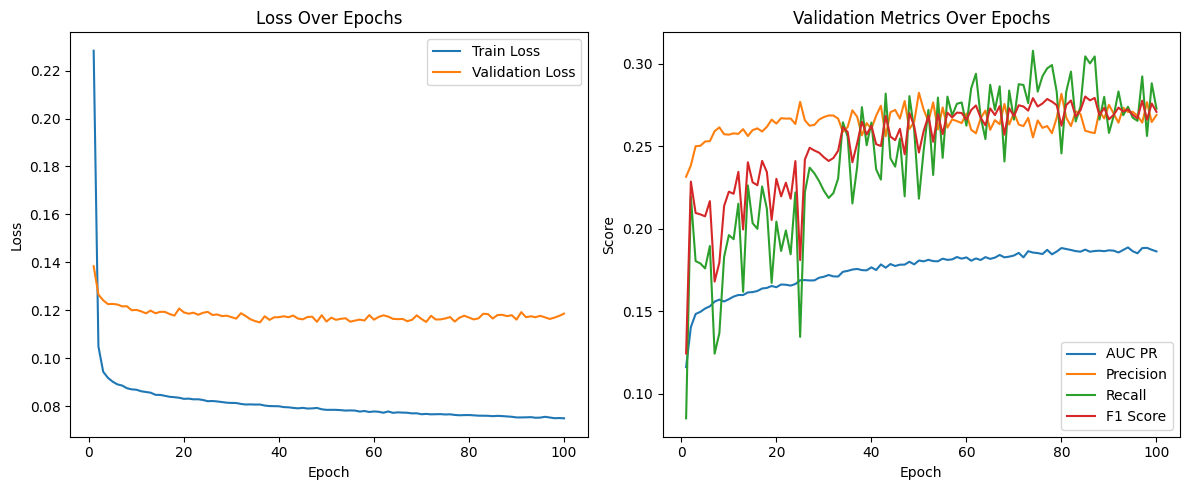

In [48]:
plot_training_history(history)

In [38]:
param_grid = {
    'initial_filters': [16, 32, 64],               # Try 16, 32, or 64 filters in first layer
    'n_encoder_blocks': [1, 2, 3, 4],              # Try 1, 2, 3, or 4 encoder blocks
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],          # Try different dropout rates
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001], # Try different learning rates
    'batch_size': [32, 64, 128, 256]               # Try different batch sizes
}

#### Test with different parameters/hyperparameters

In [39]:
params_config = {
    'in_channels': 12,
    'out_channels': 1,
    'encoder_layers': [16, 16, 32],
    'decoder_layers': [32, 16],
    'encoder_pools': [1, 2, 2],
    'decoder_pools': [2, 2],
    'dropout': 0.1,
    'batch_norm': True
}

In [42]:
#model_withlr = []
lr_list = [0.01, 0.001,0.00001]
history_withlr = []
final_metrics_withlr = []
for lr in lr_list:
    print(f"learning rate: {lr}")
    model = Autoencoder(**params_config)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_trained, history, final_metrics = train_model(model, train_loader, val_loader, lr=lr, pos_weight=pos_weight, num_epochs=num_epochs, device=device)
    #model_withlr.append(model_trained)
    history_withlr.append(history)
    final_metrics_withlr.append(final_metrics)

learning rate: 0.01


[Epoch 1/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.45it/s]


New best model with AUC PR: 0.1473
Epoch [1/100] Train Loss: 0.1040 Val Loss: 0.1265 AUC PR: 0.1473 Precision: 0.2065 Recall: 0.0294 F1: 0.0515


[Epoch 2/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.71it/s]


Epoch [2/100] Train Loss: 0.0885 Val Loss: 0.1232 AUC PR: 0.1455 Precision: 0.2363 Recall: 0.1187 F1: 0.1580


[Epoch 3/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.95it/s]


New best model with AUC PR: 0.1508
Epoch [3/100] Train Loss: 0.0872 Val Loss: 0.1205 AUC PR: 0.1508 Precision: 0.1243 Recall: 0.0002 F1: 0.0004


[Epoch 4/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.58it/s]


New best model with AUC PR: 0.1516
Epoch [4/100] Train Loss: 0.0870 Val Loss: 0.1174 AUC PR: 0.1516 Precision: 0.2430 Recall: 0.1363 F1: 0.1746


[Epoch 5/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.80it/s]


New best model with AUC PR: 0.1575
Epoch [5/100] Train Loss: 0.0856 Val Loss: 0.1250 AUC PR: 0.1575 Precision: 0.2522 Recall: 0.1154 F1: 0.1584


[Epoch 6/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.61it/s]


New best model with AUC PR: 0.1635
Epoch [6/100] Train Loss: 0.0848 Val Loss: 0.1140 AUC PR: 0.1635 Precision: 0.2741 Recall: 0.0871 F1: 0.1322


[Epoch 7/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.05it/s]


New best model with AUC PR: 0.1643
Epoch [7/100] Train Loss: 0.0843 Val Loss: 0.1238 AUC PR: 0.1643 Precision: 0.2670 Recall: 0.1333 F1: 0.1779


[Epoch 8/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.56it/s]


Epoch [8/100] Train Loss: 0.0835 Val Loss: 0.1182 AUC PR: 0.1582 Precision: 0.2555 Recall: 0.1395 F1: 0.1805


[Epoch 9/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.06it/s]


Epoch [9/100] Train Loss: 0.0829 Val Loss: 0.1207 AUC PR: 0.1641 Precision: 0.2560 Recall: 0.2433 F1: 0.2495


[Epoch 10/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.67it/s]


New best model with AUC PR: 0.1710
Epoch [10/100] Train Loss: 0.0832 Val Loss: 0.1245 AUC PR: 0.1710 Precision: 0.2831 Recall: 0.1058 F1: 0.1541


[Epoch 11/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.65it/s]


Epoch [11/100] Train Loss: 0.0822 Val Loss: 0.1191 AUC PR: 0.1686 Precision: 0.2841 Recall: 0.1129 F1: 0.1616


[Epoch 12/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 100.17it/s]


Epoch [12/100] Train Loss: 0.0816 Val Loss: 0.1244 AUC PR: 0.1692 Precision: 0.2862 Recall: 0.0841 F1: 0.1300


[Epoch 13/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.25it/s]


New best model with AUC PR: 0.1737
Epoch [13/100] Train Loss: 0.0813 Val Loss: 0.1141 AUC PR: 0.1737 Precision: 0.2714 Recall: 0.2033 F1: 0.2324


[Epoch 14/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.22it/s]


New best model with AUC PR: 0.1739
Epoch [14/100] Train Loss: 0.0813 Val Loss: 0.1174 AUC PR: 0.1739 Precision: 0.3080 Recall: 0.0572 F1: 0.0965


[Epoch 15/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.61it/s]


Epoch [15/100] Train Loss: 0.0813 Val Loss: 0.1160 AUC PR: 0.1737 Precision: 0.3017 Recall: 0.0831 F1: 0.1303


[Epoch 16/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.74it/s]


Epoch [16/100] Train Loss: 0.0806 Val Loss: 0.1199 AUC PR: 0.1725 Precision: 0.2753 Recall: 0.1785 F1: 0.2166


[Epoch 17/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.12it/s]


Epoch [17/100] Train Loss: 0.0809 Val Loss: 0.1178 AUC PR: 0.1730 Precision: 0.2543 Recall: 0.2789 F1: 0.2660


[Epoch 18/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 95.47it/s]


New best model with AUC PR: 0.1747
Epoch [18/100] Train Loss: 0.0803 Val Loss: 0.1173 AUC PR: 0.1747 Precision: 0.2801 Recall: 0.1942 F1: 0.2294


[Epoch 19/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.86it/s]


Epoch [19/100] Train Loss: 0.0801 Val Loss: 0.1167 AUC PR: 0.1691 Precision: 0.2695 Recall: 0.1798 F1: 0.2157


[Epoch 20/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.89it/s]


New best model with AUC PR: 0.1806
Epoch [20/100] Train Loss: 0.0796 Val Loss: 0.1154 AUC PR: 0.1806 Precision: 0.2719 Recall: 0.2464 F1: 0.2585


[Epoch 21/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.85it/s]


Epoch [21/100] Train Loss: 0.0794 Val Loss: 0.1188 AUC PR: 0.1788 Precision: 0.3001 Recall: 0.1442 F1: 0.1948


[Epoch 22/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.05it/s]


Epoch [22/100] Train Loss: 0.0795 Val Loss: 0.1180 AUC PR: 0.1744 Precision: 0.3021 Recall: 0.0551 F1: 0.0932


[Epoch 23/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.55it/s]


New best model with AUC PR: 0.1823
Epoch [23/100] Train Loss: 0.0793 Val Loss: 0.1175 AUC PR: 0.1823 Precision: 0.2844 Recall: 0.2136 F1: 0.2440


[Epoch 24/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.78it/s]


Epoch [24/100] Train Loss: 0.0786 Val Loss: 0.1124 AUC PR: 0.1797 Precision: 0.2814 Recall: 0.1833 F1: 0.2220


[Epoch 25/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.06it/s]


Epoch [25/100] Train Loss: 0.0789 Val Loss: 0.1146 AUC PR: 0.1795 Precision: 0.2862 Recall: 0.1889 F1: 0.2276


[Epoch 26/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.00it/s]


New best model with AUC PR: 0.1836
Epoch [26/100] Train Loss: 0.0781 Val Loss: 0.1154 AUC PR: 0.1836 Precision: 0.2790 Recall: 0.2358 F1: 0.2556


[Epoch 27/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.79it/s]


Epoch [27/100] Train Loss: 0.0780 Val Loss: 0.1266 AUC PR: 0.1773 Precision: 0.2716 Recall: 0.2194 F1: 0.2428


[Epoch 28/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.57it/s]


Epoch [28/100] Train Loss: 0.0779 Val Loss: 0.1170 AUC PR: 0.1756 Precision: 0.2628 Recall: 0.2596 F1: 0.2612


[Epoch 29/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.87it/s]


New best model with AUC PR: 0.1843
Epoch [29/100] Train Loss: 0.0778 Val Loss: 0.1197 AUC PR: 0.1843 Precision: 0.2921 Recall: 0.1823 F1: 0.2245


[Epoch 30/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.92it/s]


Epoch [30/100] Train Loss: 0.0776 Val Loss: 0.1177 AUC PR: 0.1838 Precision: 0.2696 Recall: 0.2659 F1: 0.2677


[Epoch 31/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.57it/s]


Epoch [31/100] Train Loss: 0.0771 Val Loss: 0.1185 AUC PR: 0.1794 Precision: 0.3090 Recall: 0.1176 F1: 0.1704


[Epoch 32/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.96it/s]


Epoch [32/100] Train Loss: 0.0772 Val Loss: 0.1121 AUC PR: 0.1834 Precision: 0.2796 Recall: 0.2241 F1: 0.2488


[Epoch 33/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.38it/s]


Epoch [33/100] Train Loss: 0.0774 Val Loss: 0.1196 AUC PR: 0.1801 Precision: 0.3019 Recall: 0.1450 F1: 0.1959


[Epoch 34/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.76it/s]


Epoch [34/100] Train Loss: 0.0770 Val Loss: 0.1203 AUC PR: 0.1833 Precision: 0.2803 Recall: 0.2244 F1: 0.2493


[Epoch 35/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.75it/s]


Epoch [35/100] Train Loss: 0.0769 Val Loss: 0.1190 AUC PR: 0.1813 Precision: 0.2681 Recall: 0.2691 F1: 0.2686


[Epoch 36/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.99it/s]


New best model with AUC PR: 0.1860
Epoch [36/100] Train Loss: 0.0769 Val Loss: 0.1146 AUC PR: 0.1860 Precision: 0.2873 Recall: 0.2224 F1: 0.2507


[Epoch 37/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.62it/s]


Epoch [37/100] Train Loss: 0.0765 Val Loss: 0.1129 AUC PR: 0.1838 Precision: 0.2701 Recall: 0.2798 F1: 0.2748


[Epoch 38/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.55it/s]


Epoch [38/100] Train Loss: 0.0762 Val Loss: 0.1187 AUC PR: 0.1825 Precision: 0.2688 Recall: 0.2658 F1: 0.2673


[Epoch 39/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.68it/s]


Epoch [39/100] Train Loss: 0.0761 Val Loss: 0.1169 AUC PR: 0.1768 Precision: 0.2424 Recall: 0.3379 F1: 0.2823


[Epoch 40/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.29it/s]


Epoch [40/100] Train Loss: 0.0764 Val Loss: 0.1201 AUC PR: 0.1811 Precision: 0.2938 Recall: 0.1749 F1: 0.2193


[Epoch 41/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.85it/s]


Epoch [41/100] Train Loss: 0.0756 Val Loss: 0.1123 AUC PR: 0.1857 Precision: 0.2719 Recall: 0.2605 F1: 0.2661


[Epoch 42/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.52it/s]


Epoch [42/100] Train Loss: 0.0760 Val Loss: 0.1161 AUC PR: 0.1842 Precision: 0.2907 Recall: 0.2079 F1: 0.2425


[Epoch 43/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.11it/s]


Epoch [43/100] Train Loss: 0.0755 Val Loss: 0.1216 AUC PR: 0.1842 Precision: 0.2619 Recall: 0.3047 F1: 0.2817


[Epoch 44/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.24it/s]


New best model with AUC PR: 0.1875
Epoch [44/100] Train Loss: 0.0759 Val Loss: 0.1216 AUC PR: 0.1875 Precision: 0.2837 Recall: 0.2361 F1: 0.2577


[Epoch 45/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.79it/s]


Epoch [45/100] Train Loss: 0.0757 Val Loss: 0.1201 AUC PR: 0.1794 Precision: 0.2742 Recall: 0.2378 F1: 0.2547


[Epoch 46/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.71it/s]


Epoch [46/100] Train Loss: 0.0756 Val Loss: 0.1120 AUC PR: 0.1782 Precision: 0.2775 Recall: 0.2282 F1: 0.2504


[Epoch 47/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.39it/s]


Epoch [47/100] Train Loss: 0.0755 Val Loss: 0.1124 AUC PR: 0.1841 Precision: 0.3045 Recall: 0.1549 F1: 0.2054


[Epoch 48/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.71it/s]


New best model with AUC PR: 0.1877
Epoch [48/100] Train Loss: 0.0758 Val Loss: 0.1194 AUC PR: 0.1877 Precision: 0.2766 Recall: 0.2523 F1: 0.2639


[Epoch 49/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.51it/s]


Epoch [49/100] Train Loss: 0.0752 Val Loss: 0.1198 AUC PR: 0.1829 Precision: 0.2625 Recall: 0.2934 F1: 0.2771


[Epoch 50/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.36it/s]


Epoch [50/100] Train Loss: 0.0752 Val Loss: 0.1198 AUC PR: 0.1855 Precision: 0.2740 Recall: 0.2538 F1: 0.2635


[Epoch 51/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.71it/s]


New best model with AUC PR: 0.1885
Epoch [51/100] Train Loss: 0.0749 Val Loss: 0.1143 AUC PR: 0.1885 Precision: 0.2875 Recall: 0.2110 F1: 0.2434


[Epoch 52/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.27it/s]


New best model with AUC PR: 0.1898
Epoch [52/100] Train Loss: 0.0753 Val Loss: 0.1155 AUC PR: 0.1898 Precision: 0.2990 Recall: 0.1754 F1: 0.2211


[Epoch 53/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.67it/s]


Epoch [53/100] Train Loss: 0.0746 Val Loss: 0.1151 AUC PR: 0.1892 Precision: 0.2668 Recall: 0.2805 F1: 0.2735


[Epoch 54/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.34it/s]


Epoch [54/100] Train Loss: 0.0746 Val Loss: 0.1196 AUC PR: 0.1889 Precision: 0.2803 Recall: 0.2438 F1: 0.2608


[Epoch 55/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.52it/s]


Epoch [55/100] Train Loss: 0.0747 Val Loss: 0.1166 AUC PR: 0.1828 Precision: 0.2751 Recall: 0.2368 F1: 0.2545


[Epoch 56/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.36it/s]


Epoch [56/100] Train Loss: 0.0746 Val Loss: 0.1124 AUC PR: 0.1830 Precision: 0.3143 Recall: 0.1259 F1: 0.1798


[Epoch 57/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.43it/s]


Epoch [57/100] Train Loss: 0.0750 Val Loss: 0.1263 AUC PR: 0.1869 Precision: 0.2515 Recall: 0.3243 F1: 0.2833


[Epoch 58/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.74it/s]


Epoch [58/100] Train Loss: 0.0743 Val Loss: 0.1186 AUC PR: 0.1837 Precision: 0.2584 Recall: 0.2998 F1: 0.2776


[Epoch 59/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.65it/s]


Epoch [59/100] Train Loss: 0.0745 Val Loss: 0.1201 AUC PR: 0.1823 Precision: 0.2663 Recall: 0.2682 F1: 0.2673


[Epoch 60/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.31it/s]


Epoch [60/100] Train Loss: 0.0740 Val Loss: 0.1127 AUC PR: 0.1839 Precision: 0.2985 Recall: 0.1777 F1: 0.2228


[Epoch 61/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.44it/s]


Epoch [61/100] Train Loss: 0.0743 Val Loss: 0.1201 AUC PR: 0.1862 Precision: 0.2819 Recall: 0.2254 F1: 0.2505


[Epoch 62/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.00it/s]


Epoch [62/100] Train Loss: 0.0744 Val Loss: 0.1177 AUC PR: 0.1818 Precision: 0.2655 Recall: 0.2679 F1: 0.2667


[Epoch 63/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 101.93it/s]


Epoch [63/100] Train Loss: 0.0742 Val Loss: 0.1190 AUC PR: 0.1835 Precision: 0.2684 Recall: 0.2636 F1: 0.2660


[Epoch 64/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.97it/s]


Epoch [64/100] Train Loss: 0.0741 Val Loss: 0.1190 AUC PR: 0.1873 Precision: 0.2897 Recall: 0.2153 F1: 0.2470


[Epoch 65/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.13it/s]


Epoch [65/100] Train Loss: 0.0739 Val Loss: 0.1144 AUC PR: 0.1895 Precision: 0.3079 Recall: 0.1777 F1: 0.2253


[Epoch 66/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.44it/s]


Epoch [66/100] Train Loss: 0.0737 Val Loss: 0.1189 AUC PR: 0.1832 Precision: 0.2613 Recall: 0.2953 F1: 0.2772


[Epoch 67/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.73it/s]


Epoch [67/100] Train Loss: 0.0737 Val Loss: 0.1204 AUC PR: 0.1871 Precision: 0.2852 Recall: 0.2218 F1: 0.2496


[Epoch 68/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.56it/s]


Epoch [68/100] Train Loss: 0.0738 Val Loss: 0.1222 AUC PR: 0.1833 Precision: 0.2737 Recall: 0.2535 F1: 0.2632


[Epoch 69/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.48it/s]


Epoch [69/100] Train Loss: 0.0737 Val Loss: 0.1194 AUC PR: 0.1843 Precision: 0.2770 Recall: 0.2422 F1: 0.2585


[Epoch 70/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.53it/s]


Epoch [70/100] Train Loss: 0.0734 Val Loss: 0.1170 AUC PR: 0.1850 Precision: 0.2768 Recall: 0.2452 F1: 0.2601


[Epoch 71/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.36it/s]


Epoch [71/100] Train Loss: 0.0733 Val Loss: 0.1203 AUC PR: 0.1807 Precision: 0.2795 Recall: 0.2326 F1: 0.2539


[Epoch 72/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.14it/s]


Epoch [72/100] Train Loss: 0.0739 Val Loss: 0.1207 AUC PR: 0.1824 Precision: 0.2581 Recall: 0.3005 F1: 0.2777


[Epoch 73/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.56it/s]


Epoch [73/100] Train Loss: 0.0735 Val Loss: 0.1202 AUC PR: 0.1833 Precision: 0.3047 Recall: 0.1542 F1: 0.2048


[Epoch 74/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.33it/s]


Epoch [74/100] Train Loss: 0.0731 Val Loss: 0.1131 AUC PR: 0.1812 Precision: 0.2841 Recall: 0.2149 F1: 0.2447


[Epoch 75/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.65it/s]


Epoch [75/100] Train Loss: 0.0732 Val Loss: 0.1185 AUC PR: 0.1854 Precision: 0.2644 Recall: 0.2825 F1: 0.2732


[Epoch 76/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.75it/s]


Epoch [76/100] Train Loss: 0.0733 Val Loss: 0.1203 AUC PR: 0.1822 Precision: 0.2739 Recall: 0.2534 F1: 0.2633


[Epoch 77/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.47it/s]


Epoch [77/100] Train Loss: 0.0730 Val Loss: 0.1193 AUC PR: 0.1806 Precision: 0.2914 Recall: 0.1960 F1: 0.2344


[Epoch 78/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.17it/s]


Epoch [78/100] Train Loss: 0.0734 Val Loss: 0.1154 AUC PR: 0.1858 Precision: 0.2727 Recall: 0.2585 F1: 0.2654


[Epoch 79/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.57it/s]


Epoch [79/100] Train Loss: 0.0729 Val Loss: 0.1287 AUC PR: 0.1833 Precision: 0.2382 Recall: 0.3586 F1: 0.2863


[Epoch 80/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.06it/s]


Epoch [80/100] Train Loss: 0.0728 Val Loss: 0.1204 AUC PR: 0.1858 Precision: 0.2725 Recall: 0.2615 F1: 0.2669


[Epoch 81/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.51it/s]


Epoch [81/100] Train Loss: 0.0730 Val Loss: 0.1131 AUC PR: 0.1870 Precision: 0.2896 Recall: 0.2186 F1: 0.2492


[Epoch 82/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.37it/s]


Epoch [82/100] Train Loss: 0.0733 Val Loss: 0.1178 AUC PR: 0.1830 Precision: 0.2765 Recall: 0.2460 F1: 0.2604


[Epoch 83/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.86it/s]


Epoch [83/100] Train Loss: 0.0731 Val Loss: 0.1155 AUC PR: 0.1799 Precision: 0.2733 Recall: 0.2414 F1: 0.2563


[Epoch 84/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.43it/s]


Epoch [84/100] Train Loss: 0.0732 Val Loss: 0.1150 AUC PR: 0.1826 Precision: 0.2846 Recall: 0.2098 F1: 0.2415


[Epoch 85/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.31it/s]


Epoch [85/100] Train Loss: 0.0727 Val Loss: 0.1144 AUC PR: 0.1888 Precision: 0.2698 Recall: 0.2783 F1: 0.2740


[Epoch 86/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.40it/s]


Epoch [86/100] Train Loss: 0.0729 Val Loss: 0.1140 AUC PR: 0.1842 Precision: 0.2996 Recall: 0.1812 F1: 0.2259


[Epoch 87/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.87it/s]


Epoch [87/100] Train Loss: 0.0728 Val Loss: 0.1151 AUC PR: 0.1866 Precision: 0.2819 Recall: 0.2405 F1: 0.2596


[Epoch 88/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.55it/s]


Epoch [88/100] Train Loss: 0.0722 Val Loss: 0.1203 AUC PR: 0.1844 Precision: 0.2744 Recall: 0.2486 F1: 0.2609


[Epoch 89/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.45it/s]


Epoch [89/100] Train Loss: 0.0723 Val Loss: 0.1158 AUC PR: 0.1844 Precision: 0.2965 Recall: 0.1875 F1: 0.2297


[Epoch 90/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.74it/s]


Epoch [90/100] Train Loss: 0.0725 Val Loss: 0.1201 AUC PR: 0.1821 Precision: 0.2857 Recall: 0.2097 F1: 0.2418


[Epoch 91/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.42it/s]


Epoch [91/100] Train Loss: 0.0726 Val Loss: 0.1226 AUC PR: 0.1848 Precision: 0.2795 Recall: 0.2241 F1: 0.2487


[Epoch 92/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.03it/s]


Epoch [92/100] Train Loss: 0.0722 Val Loss: 0.1123 AUC PR: 0.1837 Precision: 0.2921 Recall: 0.1858 F1: 0.2271


[Epoch 93/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.56it/s]


Epoch [93/100] Train Loss: 0.0719 Val Loss: 0.1184 AUC PR: 0.1860 Precision: 0.2765 Recall: 0.2480 F1: 0.2615


[Epoch 94/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.35it/s]


Epoch [94/100] Train Loss: 0.0723 Val Loss: 0.1205 AUC PR: 0.1861 Precision: 0.2861 Recall: 0.2167 F1: 0.2466


[Epoch 95/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.22it/s]


Epoch [95/100] Train Loss: 0.0722 Val Loss: 0.1188 AUC PR: 0.1828 Precision: 0.2596 Recall: 0.2795 F1: 0.2692


[Epoch 96/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.69it/s]


Epoch [96/100] Train Loss: 0.0722 Val Loss: 0.1212 AUC PR: 0.1812 Precision: 0.2818 Recall: 0.2018 F1: 0.2352


[Epoch 97/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.38it/s]


Epoch [97/100] Train Loss: 0.0718 Val Loss: 0.1147 AUC PR: 0.1833 Precision: 0.2726 Recall: 0.2533 F1: 0.2626


[Epoch 98/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.82it/s]


Epoch [98/100] Train Loss: 0.0721 Val Loss: 0.1123 AUC PR: 0.1804 Precision: 0.2865 Recall: 0.1922 F1: 0.2301


[Epoch 99/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.78it/s]


Epoch [99/100] Train Loss: 0.0720 Val Loss: 0.1138 AUC PR: 0.1816 Precision: 0.2820 Recall: 0.2273 F1: 0.2517


[Epoch 100/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.53it/s]


Epoch [100/100] Train Loss: 0.0721 Val Loss: 0.1121 AUC PR: 0.1851 Precision: 0.2784 Recall: 0.2484 F1: 0.2626

Final Model Performance:
AUC PR: 0.1851
Precision: 0.2784
Recall: 0.2484
F1 Score: 0.2626
learning rate: 0.001


[Epoch 1/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.53it/s]


New best model with AUC PR: 0.1500
Epoch [1/100] Train Loss: 0.1151 Val Loss: 0.1213 AUC PR: 0.1500 Precision: 0.2455 Recall: 0.1904 F1: 0.2144


[Epoch 2/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.83it/s]


New best model with AUC PR: 0.1511
Epoch [2/100] Train Loss: 0.0893 Val Loss: 0.1227 AUC PR: 0.1511 Precision: 0.2500 Recall: 0.1797 F1: 0.2091


[Epoch 6/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.95it/s]


New best model with AUC PR: 0.1656
Epoch [6/100] Train Loss: 0.0838 Val Loss: 0.1175 AUC PR: 0.1656 Precision: 0.2694 Recall: 0.1503 F1: 0.1930


[Epoch 7/100] Training:  95%|█████████▌| 446/469 [00:11<00:00, 40.62it/s]

New best model with AUC PR: 0.1769
Epoch [9/100] Train Loss: 0.0814 Val Loss: 0.1142 AUC PR: 0.1769 Precision: 0.2766 Recall: 0.2149 F1: 0.2419


[Epoch 10/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.52it/s]


Epoch [10/100] Train Loss: 0.0809 Val Loss: 0.1171 AUC PR: 0.1759 Precision: 0.2735 Recall: 0.2286 F1: 0.2490


[Epoch 11/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.19it/s]


New best model with AUC PR: 0.1772
Epoch [11/100] Train Loss: 0.0806 Val Loss: 0.1186 AUC PR: 0.1772 Precision: 0.2743 Recall: 0.2327 F1: 0.2518


[Epoch 12/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.10it/s]


New best model with AUC PR: 0.1803
Epoch [12/100] Train Loss: 0.0797 Val Loss: 0.1199 AUC PR: 0.1803 Precision: 0.2727 Recall: 0.2422 F1: 0.2566


[Epoch 13/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.77it/s]


New best model with AUC PR: 0.1806
Epoch [13/100] Train Loss: 0.0795 Val Loss: 0.1170 AUC PR: 0.1806 Precision: 0.2669 Recall: 0.2515 F1: 0.2590


[Epoch 14/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.41it/s]


Epoch [17/100] Train Loss: 0.0781 Val Loss: 0.1133 AUC PR: 0.1841 Precision: 0.2602 Recall: 0.2880 F1: 0.2734


[Epoch 18/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.28it/s]


Epoch [18/100] Train Loss: 0.0778 Val Loss: 0.1153 AUC PR: 0.1841 Precision: 0.2973 Recall: 0.1842 F1: 0.2275


[Epoch 19/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.09it/s]


Epoch [19/100] Train Loss: 0.0777 Val Loss: 0.1184 AUC PR: 0.1861 Precision: 0.2936 Recall: 0.2047 F1: 0.2412


[Epoch 20/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.67it/s]


Epoch [20/100] Train Loss: 0.0775 Val Loss: 0.1165 AUC PR: 0.1863 Precision: 0.2821 Recall: 0.2417 F1: 0.2603


[Epoch 21/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.08it/s]


Epoch [21/100] Train Loss: 0.0772 Val Loss: 0.1138 AUC PR: 0.1861 Precision: 0.2738 Recall: 0.2620 F1: 0.2678


[Epoch 22/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.28it/s]


Epoch [22/100] Train Loss: 0.0770 Val Loss: 0.1145 AUC PR: 0.1876 Precision: 0.2777 Recall: 0.2524 F1: 0.2645


[Epoch 23/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.01it/s]


Epoch [23/100] Train Loss: 0.0768 Val Loss: 0.1119 AUC PR: 0.1858 Precision: 0.2818 Recall: 0.2418 F1: 0.2603


[Epoch 24/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 100.42it/s]


Epoch [24/100] Train Loss: 0.0764 Val Loss: 0.1165 AUC PR: 0.1861 Precision: 0.2662 Recall: 0.2812 F1: 0.2735


[Epoch 25/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.23it/s]


Epoch [25/100] Train Loss: 0.0765 Val Loss: 0.1170 AUC PR: 0.1867 Precision: 0.2544 Recall: 0.3068 F1: 0.2782


[Epoch 26/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.79it/s]


Epoch [28/100] Train Loss: 0.0756 Val Loss: 0.1178 AUC PR: 0.1876 Precision: 0.2662 Recall: 0.2799 F1: 0.2729


[Epoch 29/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.01it/s]


Epoch [29/100] Train Loss: 0.0757 Val Loss: 0.1175 AUC PR: 0.1882 Precision: 0.2683 Recall: 0.2713 F1: 0.2698


[Epoch 30/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.68it/s]


Epoch [30/100] Train Loss: 0.0753 Val Loss: 0.1163 AUC PR: 0.1853 Precision: 0.2531 Recall: 0.3108 F1: 0.2790


[Epoch 31/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.68it/s]


Epoch [31/100] Train Loss: 0.0754 Val Loss: 0.1136 AUC PR: 0.1884 Precision: 0.2763 Recall: 0.2594 F1: 0.2675


[Epoch 32/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.16it/s]


Epoch [32/100] Train Loss: 0.0750 Val Loss: 0.1143 AUC PR: 0.1873 Precision: 0.2763 Recall: 0.2534 F1: 0.2644


[Epoch 33/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.63it/s]


Epoch [33/100] Train Loss: 0.0749 Val Loss: 0.1180 AUC PR: 0.1873 Precision: 0.2671 Recall: 0.2735 F1: 0.2702


[Epoch 34/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.94it/s]


Epoch [34/100] Train Loss: 0.0749 Val Loss: 0.1158 AUC PR: 0.1830 Precision: 0.2652 Recall: 0.2675 F1: 0.2663


[Epoch 35/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.66it/s]


Epoch [35/100] Train Loss: 0.0747 Val Loss: 0.1175 AUC PR: 0.1859 Precision: 0.2663 Recall: 0.2809 F1: 0.2734


[Epoch 36/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.66it/s]


Epoch [36/100] Train Loss: 0.0746 Val Loss: 0.1165 AUC PR: 0.1860 Precision: 0.2775 Recall: 0.2414 F1: 0.2582


[Epoch 37/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.28it/s]


Epoch [37/100] Train Loss: 0.0745 Val Loss: 0.1185 AUC PR: 0.1858 Precision: 0.2536 Recall: 0.3062 F1: 0.2775


[Epoch 38/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.49it/s]


Epoch [38/100] Train Loss: 0.0743 Val Loss: 0.1160 AUC PR: 0.1868 Precision: 0.2796 Recall: 0.2395 F1: 0.2580


[Epoch 39/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.13it/s]


Epoch [39/100] Train Loss: 0.0741 Val Loss: 0.1165 AUC PR: 0.1854 Precision: 0.2879 Recall: 0.2176 F1: 0.2479


[Epoch 40/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.26it/s]


Epoch [40/100] Train Loss: 0.0740 Val Loss: 0.1183 AUC PR: 0.1866 Precision: 0.2855 Recall: 0.2208 F1: 0.2490


[Epoch 41/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.30it/s]


Epoch [41/100] Train Loss: 0.0736 Val Loss: 0.1172 AUC PR: 0.1873 Precision: 0.2870 Recall: 0.2224 F1: 0.2506


[Epoch 42/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.53it/s]


Epoch [42/100] Train Loss: 0.0736 Val Loss: 0.1155 AUC PR: 0.1872 Precision: 0.2810 Recall: 0.2338 F1: 0.2552


[Epoch 43/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.06it/s]


Epoch [43/100] Train Loss: 0.0735 Val Loss: 0.1198 AUC PR: 0.1866 Precision: 0.2749 Recall: 0.2476 F1: 0.2605


[Epoch 44/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.08it/s]


Epoch [44/100] Train Loss: 0.0735 Val Loss: 0.1187 AUC PR: 0.1843 Precision: 0.2650 Recall: 0.2753 F1: 0.2700


[Epoch 45/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 96.36it/s] 


Epoch [45/100] Train Loss: 0.0732 Val Loss: 0.1174 AUC PR: 0.1876 Precision: 0.2881 Recall: 0.2279 F1: 0.2545


[Epoch 46/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.79it/s]


Epoch [46/100] Train Loss: 0.0732 Val Loss: 0.1184 AUC PR: 0.1858 Precision: 0.2575 Recall: 0.2900 F1: 0.2728


[Epoch 47/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.79it/s]


New best model with AUC PR: 0.1898
Epoch [47/100] Train Loss: 0.0732 Val Loss: 0.1167 AUC PR: 0.1898 Precision: 0.2608 Recall: 0.2979 F1: 0.2781


[Epoch 48/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.29it/s]


Epoch [48/100] Train Loss: 0.0727 Val Loss: 0.1183 AUC PR: 0.1864 Precision: 0.2646 Recall: 0.2840 F1: 0.2740


[Epoch 49/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.53it/s]


Epoch [49/100] Train Loss: 0.0726 Val Loss: 0.1198 AUC PR: 0.1838 Precision: 0.2604 Recall: 0.2800 F1: 0.2699


[Epoch 50/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.55it/s]


Epoch [50/100] Train Loss: 0.0726 Val Loss: 0.1169 AUC PR: 0.1864 Precision: 0.2458 Recall: 0.3163 F1: 0.2766


[Epoch 51/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.80it/s]


Epoch [51/100] Train Loss: 0.0726 Val Loss: 0.1172 AUC PR: 0.1811 Precision: 0.2522 Recall: 0.3025 F1: 0.2751


[Epoch 52/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.49it/s]


Epoch [52/100] Train Loss: 0.0722 Val Loss: 0.1206 AUC PR: 0.1881 Precision: 0.2667 Recall: 0.2750 F1: 0.2708


[Epoch 53/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.34it/s]


Epoch [53/100] Train Loss: 0.0726 Val Loss: 0.1193 AUC PR: 0.1869 Precision: 0.2840 Recall: 0.2334 F1: 0.2562


[Epoch 54/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.24it/s]


Epoch [54/100] Train Loss: 0.0722 Val Loss: 0.1166 AUC PR: 0.1870 Precision: 0.2613 Recall: 0.2868 F1: 0.2735


[Epoch 55/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.85it/s]


Epoch [55/100] Train Loss: 0.0722 Val Loss: 0.1149 AUC PR: 0.1891 Precision: 0.2705 Recall: 0.2678 F1: 0.2691


[Epoch 56/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 96.87it/s]


Epoch [56/100] Train Loss: 0.0719 Val Loss: 0.1174 AUC PR: 0.1857 Precision: 0.2644 Recall: 0.2698 F1: 0.2671


[Epoch 57/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.18it/s]


Epoch [57/100] Train Loss: 0.0720 Val Loss: 0.1166 AUC PR: 0.1816 Precision: 0.2731 Recall: 0.2397 F1: 0.2553


[Epoch 58/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.12it/s]


Epoch [58/100] Train Loss: 0.0719 Val Loss: 0.1191 AUC PR: 0.1865 Precision: 0.2684 Recall: 0.2725 F1: 0.2704


[Epoch 59/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.75it/s]


Epoch [59/100] Train Loss: 0.0718 Val Loss: 0.1203 AUC PR: 0.1849 Precision: 0.2843 Recall: 0.2220 F1: 0.2493


[Epoch 60/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.60it/s]


Epoch [60/100] Train Loss: 0.0717 Val Loss: 0.1169 AUC PR: 0.1855 Precision: 0.2743 Recall: 0.2545 F1: 0.2640


[Epoch 61/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.59it/s]


Epoch [61/100] Train Loss: 0.0718 Val Loss: 0.1169 AUC PR: 0.1879 Precision: 0.2818 Recall: 0.2493 F1: 0.2646


[Epoch 62/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.35it/s]


Epoch [62/100] Train Loss: 0.0715 Val Loss: 0.1185 AUC PR: 0.1870 Precision: 0.2676 Recall: 0.2684 F1: 0.2680


[Epoch 63/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.84it/s]


Epoch [63/100] Train Loss: 0.0715 Val Loss: 0.1211 AUC PR: 0.1892 Precision: 0.2775 Recall: 0.2500 F1: 0.2630


[Epoch 64/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.97it/s]


Epoch [64/100] Train Loss: 0.0714 Val Loss: 0.1178 AUC PR: 0.1884 Precision: 0.2827 Recall: 0.2283 F1: 0.2526


[Epoch 65/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.12it/s]


New best model with AUC PR: 0.1909
Epoch [65/100] Train Loss: 0.0713 Val Loss: 0.1219 AUC PR: 0.1909 Precision: 0.2692 Recall: 0.2705 F1: 0.2698


[Epoch 66/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.95it/s]


Epoch [66/100] Train Loss: 0.0716 Val Loss: 0.1202 AUC PR: 0.1873 Precision: 0.2938 Recall: 0.1996 F1: 0.2377


[Epoch 67/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.53it/s]


Epoch [67/100] Train Loss: 0.0713 Val Loss: 0.1175 AUC PR: 0.1865 Precision: 0.2876 Recall: 0.2215 F1: 0.2502


[Epoch 68/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.97it/s]


Epoch [68/100] Train Loss: 0.0711 Val Loss: 0.1163 AUC PR: 0.1892 Precision: 0.2615 Recall: 0.2888 F1: 0.2745


[Epoch 69/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.22it/s]


Epoch [69/100] Train Loss: 0.0712 Val Loss: 0.1194 AUC PR: 0.1871 Precision: 0.2877 Recall: 0.2215 F1: 0.2503


[Epoch 70/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.85it/s]


Epoch [70/100] Train Loss: 0.0709 Val Loss: 0.1189 AUC PR: 0.1894 Precision: 0.2618 Recall: 0.2840 F1: 0.2725


[Epoch 71/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.75it/s]


Epoch [71/100] Train Loss: 0.0709 Val Loss: 0.1206 AUC PR: 0.1904 Precision: 0.2905 Recall: 0.2247 F1: 0.2534


[Epoch 72/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.66it/s]


Epoch [72/100] Train Loss: 0.0708 Val Loss: 0.1209 AUC PR: 0.1843 Precision: 0.2715 Recall: 0.2555 F1: 0.2633


[Epoch 73/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.90it/s]


Epoch [73/100] Train Loss: 0.0709 Val Loss: 0.1170 AUC PR: 0.1902 Precision: 0.2838 Recall: 0.2397 F1: 0.2599


[Epoch 74/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.52it/s]


Epoch [74/100] Train Loss: 0.0708 Val Loss: 0.1202 AUC PR: 0.1874 Precision: 0.2592 Recall: 0.2949 F1: 0.2759


[Epoch 75/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.76it/s]


Epoch [75/100] Train Loss: 0.0710 Val Loss: 0.1186 AUC PR: 0.1906 Precision: 0.2989 Recall: 0.2064 F1: 0.2442


[Epoch 76/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.06it/s]


Epoch [76/100] Train Loss: 0.0703 Val Loss: 0.1197 AUC PR: 0.1872 Precision: 0.2609 Recall: 0.2878 F1: 0.2737


[Epoch 77/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.42it/s]


Epoch [77/100] Train Loss: 0.0704 Val Loss: 0.1206 AUC PR: 0.1901 Precision: 0.2927 Recall: 0.2129 F1: 0.2465


[Epoch 78/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.09it/s]


New best model with AUC PR: 0.1909
Epoch [78/100] Train Loss: 0.0703 Val Loss: 0.1165 AUC PR: 0.1909 Precision: 0.2735 Recall: 0.2685 F1: 0.2710


[Epoch 79/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.85it/s]


Epoch [79/100] Train Loss: 0.0703 Val Loss: 0.1174 AUC PR: 0.1862 Precision: 0.2597 Recall: 0.2922 F1: 0.2750


[Epoch 80/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.53it/s]


Epoch [80/100] Train Loss: 0.0704 Val Loss: 0.1168 AUC PR: 0.1900 Precision: 0.2810 Recall: 0.2496 F1: 0.2644


[Epoch 81/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.21it/s]


Epoch [81/100] Train Loss: 0.0703 Val Loss: 0.1173 AUC PR: 0.1838 Precision: 0.2686 Recall: 0.2548 F1: 0.2615


[Epoch 82/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.48it/s]


Epoch [82/100] Train Loss: 0.0702 Val Loss: 0.1181 AUC PR: 0.1850 Precision: 0.2663 Recall: 0.2738 F1: 0.2700


[Epoch 83/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.98it/s]


Epoch [83/100] Train Loss: 0.0700 Val Loss: 0.1172 AUC PR: 0.1893 Precision: 0.2880 Recall: 0.2264 F1: 0.2535


[Epoch 84/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.02it/s]


Epoch [84/100] Train Loss: 0.0700 Val Loss: 0.1191 AUC PR: 0.1900 Precision: 0.2859 Recall: 0.2314 F1: 0.2558


[Epoch 85/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.93it/s]


Epoch [85/100] Train Loss: 0.0702 Val Loss: 0.1189 AUC PR: 0.1880 Precision: 0.2748 Recall: 0.2557 F1: 0.2649


[Epoch 86/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.86it/s]


Epoch [86/100] Train Loss: 0.0703 Val Loss: 0.1181 AUC PR: 0.1872 Precision: 0.2576 Recall: 0.2969 F1: 0.2758


[Epoch 87/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 101.16it/s]


Epoch [87/100] Train Loss: 0.0702 Val Loss: 0.1210 AUC PR: 0.1884 Precision: 0.2718 Recall: 0.2724 F1: 0.2721


[Epoch 88/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.13it/s]


Epoch [88/100] Train Loss: 0.0699 Val Loss: 0.1206 AUC PR: 0.1899 Precision: 0.2681 Recall: 0.2788 F1: 0.2734


[Epoch 89/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.05it/s]


Epoch [89/100] Train Loss: 0.0698 Val Loss: 0.1189 AUC PR: 0.1867 Precision: 0.2727 Recall: 0.2592 F1: 0.2658


[Epoch 90/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.50it/s]


New best model with AUC PR: 0.1911
Epoch [90/100] Train Loss: 0.0697 Val Loss: 0.1188 AUC PR: 0.1911 Precision: 0.2781 Recall: 0.2492 F1: 0.2628


[Epoch 91/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.28it/s]


Epoch [91/100] Train Loss: 0.0700 Val Loss: 0.1194 AUC PR: 0.1895 Precision: 0.2748 Recall: 0.2641 F1: 0.2694


[Epoch 92/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.94it/s]


Epoch [92/100] Train Loss: 0.0696 Val Loss: 0.1188 AUC PR: 0.1898 Precision: 0.2846 Recall: 0.2385 F1: 0.2595


[Epoch 93/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.36it/s]


Epoch [93/100] Train Loss: 0.0694 Val Loss: 0.1167 AUC PR: 0.1908 Precision: 0.2758 Recall: 0.2637 F1: 0.2696


[Epoch 94/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.31it/s]


New best model with AUC PR: 0.1913
Epoch [94/100] Train Loss: 0.0698 Val Loss: 0.1157 AUC PR: 0.1913 Precision: 0.2941 Recall: 0.2226 F1: 0.2534


[Epoch 95/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.31it/s]


Epoch [95/100] Train Loss: 0.0696 Val Loss: 0.1196 AUC PR: 0.1861 Precision: 0.2786 Recall: 0.2397 F1: 0.2577


[Epoch 96/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.19it/s]


New best model with AUC PR: 0.1915
Epoch [96/100] Train Loss: 0.0695 Val Loss: 0.1191 AUC PR: 0.1915 Precision: 0.2890 Recall: 0.2311 F1: 0.2569


[Epoch 97/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.56it/s]


Epoch [97/100] Train Loss: 0.0699 Val Loss: 0.1204 AUC PR: 0.1865 Precision: 0.2688 Recall: 0.2676 F1: 0.2682


[Epoch 98/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.12it/s]


Epoch [98/100] Train Loss: 0.0695 Val Loss: 0.1183 AUC PR: 0.1892 Precision: 0.2814 Recall: 0.2470 F1: 0.2631


[Epoch 99/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.89it/s]


Epoch [99/100] Train Loss: 0.0694 Val Loss: 0.1193 AUC PR: 0.1883 Precision: 0.2662 Recall: 0.2800 F1: 0.2729


[Epoch 100/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.03it/s]


Epoch [100/100] Train Loss: 0.0698 Val Loss: 0.1160 AUC PR: 0.1860 Precision: 0.2598 Recall: 0.2844 F1: 0.2715

Final Model Performance:
AUC PR: 0.1860
Precision: 0.2598
Recall: 0.2844
F1 Score: 0.2715
learning rate: 1e-05


[Epoch 1/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.02it/s]


New best model with AUC PR: 0.0185
Epoch [1/100] Train Loss: 0.6554 Val Loss: 0.5500 AUC PR: 0.0185 Precision: 0.0128 Recall: 0.0039 F1: 0.0060


[Epoch 2/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.54it/s]


New best model with AUC PR: 0.0224
Epoch [2/100] Train Loss: 0.4318 Val Loss: 0.3722 AUC PR: 0.0224 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 3/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.47it/s]


Epoch [3/100] Train Loss: 0.3001 Val Loss: 0.2645 AUC PR: 0.0198 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 4/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.69it/s]


Epoch [4/100] Train Loss: 0.2279 Val Loss: 0.2148 AUC PR: 0.0199 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 5/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.40it/s]


New best model with AUC PR: 0.0232
Epoch [5/100] Train Loss: 0.1882 Val Loss: 0.1870 AUC PR: 0.0232 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 6/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.90it/s]


New best model with AUC PR: 0.0309
Epoch [6/100] Train Loss: 0.1668 Val Loss: 0.1727 AUC PR: 0.0309 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 7/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.47it/s]


New best model with AUC PR: 0.0438
Epoch [7/100] Train Loss: 0.1544 Val Loss: 0.1627 AUC PR: 0.0438 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 8/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.73it/s]


New best model with AUC PR: 0.0613
Epoch [8/100] Train Loss: 0.1465 Val Loss: 0.1557 AUC PR: 0.0613 Precision: 0.0000 Recall: 0.0000 F1: 0.0000


[Epoch 9/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.76it/s]


New best model with AUC PR: 0.0739
Epoch [9/100] Train Loss: 0.1402 Val Loss: 0.1507 AUC PR: 0.0739 Precision: 0.0526 Recall: 0.0000 F1: 0.0001


[Epoch 10/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.21it/s]


New best model with AUC PR: 0.0873
Epoch [10/100] Train Loss: 0.1353 Val Loss: 0.1464 AUC PR: 0.0873 Precision: 0.1756 Recall: 0.0038 F1: 0.0074


[Epoch 11/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.11it/s]


New best model with AUC PR: 0.0960
Epoch [11/100] Train Loss: 0.1310 Val Loss: 0.1437 AUC PR: 0.0960 Precision: 0.1976 Recall: 0.0181 F1: 0.0331


[Epoch 12/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.58it/s]


New best model with AUC PR: 0.1048
Epoch [12/100] Train Loss: 0.1277 Val Loss: 0.1421 AUC PR: 0.1048 Precision: 0.2085 Recall: 0.0378 F1: 0.0640


[Epoch 13/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.61it/s]


New best model with AUC PR: 0.1126
Epoch [13/100] Train Loss: 0.1227 Val Loss: 0.1409 AUC PR: 0.1126 Precision: 0.2261 Recall: 0.0721 F1: 0.1094


[Epoch 14/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.95it/s]


New best model with AUC PR: 0.1193
Epoch [14/100] Train Loss: 0.1184 Val Loss: 0.1382 AUC PR: 0.1193 Precision: 0.2336 Recall: 0.1193 F1: 0.1580


[Epoch 15/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.14it/s]


New best model with AUC PR: 0.1236
Epoch [15/100] Train Loss: 0.1141 Val Loss: 0.1371 AUC PR: 0.1236 Precision: 0.2336 Recall: 0.1427 F1: 0.1772


[Epoch 16/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.84it/s]


New best model with AUC PR: 0.1273
Epoch [16/100] Train Loss: 0.1110 Val Loss: 0.1352 AUC PR: 0.1273 Precision: 0.2328 Recall: 0.1823 F1: 0.2045


[Epoch 17/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.48it/s]


New best model with AUC PR: 0.1305
Epoch [17/100] Train Loss: 0.1083 Val Loss: 0.1346 AUC PR: 0.1305 Precision: 0.2319 Recall: 0.2064 F1: 0.2184


[Epoch 18/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.20it/s]


New best model with AUC PR: 0.1350
Epoch [18/100] Train Loss: 0.1063 Val Loss: 0.1316 AUC PR: 0.1350 Precision: 0.2297 Recall: 0.2284 F1: 0.2291


[Epoch 19/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.41it/s]


New best model with AUC PR: 0.1378
Epoch [19/100] Train Loss: 0.1044 Val Loss: 0.1311 AUC PR: 0.1378 Precision: 0.2286 Recall: 0.2497 F1: 0.2387


[Epoch 20/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.04it/s]


New best model with AUC PR: 0.1405
Epoch [20/100] Train Loss: 0.1024 Val Loss: 0.1312 AUC PR: 0.1405 Precision: 0.2295 Recall: 0.2578 F1: 0.2428


[Epoch 21/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.34it/s]


New best model with AUC PR: 0.1433
Epoch [21/100] Train Loss: 0.1011 Val Loss: 0.1299 AUC PR: 0.1433 Precision: 0.2328 Recall: 0.2480 F1: 0.2402


[Epoch 22/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.10it/s]


New best model with AUC PR: 0.1452
Epoch [22/100] Train Loss: 0.1001 Val Loss: 0.1286 AUC PR: 0.1452 Precision: 0.2307 Recall: 0.2655 F1: 0.2469


[Epoch 23/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.74it/s]


New best model with AUC PR: 0.1465
Epoch [23/100] Train Loss: 0.0993 Val Loss: 0.1292 AUC PR: 0.1465 Precision: 0.2402 Recall: 0.2296 F1: 0.2348


[Epoch 24/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.58it/s]


New best model with AUC PR: 0.1484
Epoch [24/100] Train Loss: 0.0985 Val Loss: 0.1279 AUC PR: 0.1484 Precision: 0.2357 Recall: 0.2610 F1: 0.2477


[Epoch 25/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.16it/s]


New best model with AUC PR: 0.1494
Epoch [25/100] Train Loss: 0.0976 Val Loss: 0.1280 AUC PR: 0.1494 Precision: 0.2372 Recall: 0.2561 F1: 0.2463


[Epoch 26/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 96.28it/s]


New best model with AUC PR: 0.1495
Epoch [26/100] Train Loss: 0.0971 Val Loss: 0.1272 AUC PR: 0.1495 Precision: 0.2384 Recall: 0.2526 F1: 0.2453


[Epoch 30/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.47it/s]


New best model with AUC PR: 0.1510
Epoch [30/100] Train Loss: 0.0949 Val Loss: 0.1267 AUC PR: 0.1510 Precision: 0.2450 Recall: 0.2342 F1: 0.2395


[Epoch 31/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.76it/s]


New best model with AUC PR: 0.1515
Epoch [31/100] Train Loss: 0.0942 Val Loss: 0.1261 AUC PR: 0.1515 Precision: 0.2488 Recall: 0.2144 F1: 0.2303


[Epoch 32/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.39it/s]


New best model with AUC PR: 0.1516
Epoch [32/100] Train Loss: 0.0939 Val Loss: 0.1264 AUC PR: 0.1516 Precision: 0.2503 Recall: 0.2072 F1: 0.2267


[Epoch 33/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.75it/s]


Epoch [33/100] Train Loss: 0.0936 Val Loss: 0.1260 AUC PR: 0.1506 Precision: 0.2445 Recall: 0.2386 F1: 0.2415


[Epoch 34/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.36it/s]


Epoch [34/100] Train Loss: 0.0932 Val Loss: 0.1254 AUC PR: 0.1515 Precision: 0.2505 Recall: 0.2124 F1: 0.2299


[Epoch 35/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.46it/s]


New best model with AUC PR: 0.1517
Epoch [35/100] Train Loss: 0.0926 Val Loss: 0.1252 AUC PR: 0.1517 Precision: 0.2501 Recall: 0.2172 F1: 0.2325


[Epoch 36/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.22it/s]


New best model with AUC PR: 0.1533
Epoch [38/100] Train Loss: 0.0921 Val Loss: 0.1254 AUC PR: 0.1533 Precision: 0.2523 Recall: 0.2084 F1: 0.2282


[Epoch 39/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.40it/s]


Epoch [39/100] Train Loss: 0.0918 Val Loss: 0.1252 AUC PR: 0.1529 Precision: 0.2508 Recall: 0.2195 F1: 0.2341


[Epoch 40/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.29it/s]


New best model with AUC PR: 0.1539
Epoch [40/100] Train Loss: 0.0915 Val Loss: 0.1247 AUC PR: 0.1539 Precision: 0.2525 Recall: 0.2125 F1: 0.2308


[Epoch 41/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.36it/s]


Epoch [41/100] Train Loss: 0.0914 Val Loss: 0.1240 AUC PR: 0.1538 Precision: 0.2515 Recall: 0.2191 F1: 0.2342


[Epoch 42/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.31it/s]


Epoch [42/100] Train Loss: 0.0911 Val Loss: 0.1239 AUC PR: 0.1538 Precision: 0.2498 Recall: 0.2295 F1: 0.2392


[Epoch 43/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.14it/s]


Epoch [43/100] Train Loss: 0.0909 Val Loss: 0.1251 AUC PR: 0.1535 Precision: 0.2542 Recall: 0.2024 F1: 0.2254


[Epoch 44/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.18it/s]


New best model with AUC PR: 0.1543
Epoch [44/100] Train Loss: 0.0903 Val Loss: 0.1263 AUC PR: 0.1543 Precision: 0.2571 Recall: 0.1742 F1: 0.2077


[Epoch 48/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.47it/s]


Epoch [48/100] Train Loss: 0.0899 Val Loss: 0.1247 AUC PR: 0.1551 Precision: 0.2552 Recall: 0.2078 F1: 0.2291


[Epoch 49/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.17it/s]


New best model with AUC PR: 0.1558
Epoch [49/100] Train Loss: 0.0896 Val Loss: 0.1228 AUC PR: 0.1558 Precision: 0.2546 Recall: 0.2113 F1: 0.2309


[Epoch 50/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.59it/s]


Epoch [50/100] Train Loss: 0.0895 Val Loss: 0.1231 AUC PR: 0.1549 Precision: 0.2523 Recall: 0.2259 F1: 0.2384


[Epoch 51/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.93it/s]


Epoch [51/100] Train Loss: 0.0894 Val Loss: 0.1233 AUC PR: 0.1556 Precision: 0.2526 Recall: 0.2272 F1: 0.2392


[Epoch 52/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.61it/s]


Epoch [52/100] Train Loss: 0.0893 Val Loss: 0.1232 AUC PR: 0.1557 Precision: 0.2568 Recall: 0.2011 F1: 0.2256


[Epoch 53/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 96.93it/s]


New best model with AUC PR: 0.1565
Epoch [53/100] Train Loss: 0.0894 Val Loss: 0.1238 AUC PR: 0.1565 Precision: 0.2587 Recall: 0.1833 F1: 0.2146


[Epoch 57/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.78it/s]


New best model with AUC PR: 0.1569
Epoch [57/100] Train Loss: 0.0888 Val Loss: 0.1232 AUC PR: 0.1569 Precision: 0.2583 Recall: 0.1936 F1: 0.2213


[Epoch 58/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.66it/s]


Epoch [58/100] Train Loss: 0.0886 Val Loss: 0.1226 AUC PR: 0.1561 Precision: 0.2543 Recall: 0.2232 F1: 0.2377


[Epoch 59/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.16it/s]


Epoch [59/100] Train Loss: 0.0883 Val Loss: 0.1221 AUC PR: 0.1567 Precision: 0.2552 Recall: 0.2225 F1: 0.2377


[Epoch 60/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.99it/s]


Epoch [60/100] Train Loss: 0.0882 Val Loss: 0.1227 AUC PR: 0.1567 Precision: 0.2555 Recall: 0.2164 F1: 0.2343


[Epoch 61/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.32it/s]


New best model with AUC PR: 0.1577
Epoch [61/100] Train Loss: 0.0882 Val Loss: 0.1217 AUC PR: 0.1577 Precision: 0.2579 Recall: 0.2039 F1: 0.2278


[Epoch 62/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.55it/s]


Epoch [62/100] Train Loss: 0.0880 Val Loss: 0.1228 AUC PR: 0.1571 Precision: 0.2571 Recall: 0.2077 F1: 0.2298


[Epoch 63/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.30it/s]


New best model with AUC PR: 0.1583
Epoch [63/100] Train Loss: 0.0878 Val Loss: 0.1216 AUC PR: 0.1583 Precision: 0.2595 Recall: 0.1882 F1: 0.2181


[Epoch 64/100] Training:  69%|██████▉   | 325/469 [00:08<00:03, 39.48it/s]

Epoch [66/100] Train Loss: 0.0880 Val Loss: 0.1218 AUC PR: 0.1575 Precision: 0.2552 Recall: 0.2261 F1: 0.2398


[Epoch 67/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.58it/s]


Epoch [67/100] Train Loss: 0.0878 Val Loss: 0.1213 AUC PR: 0.1582 Precision: 0.2575 Recall: 0.2122 F1: 0.2327


[Epoch 68/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.27it/s]


New best model with AUC PR: 0.1583
Epoch [68/100] Train Loss: 0.0873 Val Loss: 0.1221 AUC PR: 0.1583 Precision: 0.2580 Recall: 0.2080 F1: 0.2303


[Epoch 69/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.56it/s]


Epoch [69/100] Train Loss: 0.0873 Val Loss: 0.1222 AUC PR: 0.1580 Precision: 0.2595 Recall: 0.1969 F1: 0.2239


[Epoch 70/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 114.08it/s]


Epoch [70/100] Train Loss: 0.0875 Val Loss: 0.1213 AUC PR: 0.1578 Precision: 0.2581 Recall: 0.2083 F1: 0.2305


[Epoch 71/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.37it/s]


New best model with AUC PR: 0.1584
Epoch [71/100] Train Loss: 0.0871 Val Loss: 0.1218 AUC PR: 0.1584 Precision: 0.2560 Recall: 0.2249 F1: 0.2395


[Epoch 72/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.88it/s]


Epoch [72/100] Train Loss: 0.0875 Val Loss: 0.1215 AUC PR: 0.1584 Precision: 0.2555 Recall: 0.2298 F1: 0.2420


[Epoch 73/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.26it/s]


New best model with AUC PR: 0.1594
Epoch [75/100] Train Loss: 0.0870 Val Loss: 0.1210 AUC PR: 0.1594 Precision: 0.2596 Recall: 0.2065 F1: 0.2300


[Epoch 76/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.77it/s]


New best model with AUC PR: 0.1598
Epoch [76/100] Train Loss: 0.0868 Val Loss: 0.1222 AUC PR: 0.1598 Precision: 0.2617 Recall: 0.1808 F1: 0.2139


[Epoch 77/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 107.86it/s]


Epoch [77/100] Train Loss: 0.0869 Val Loss: 0.1209 AUC PR: 0.1597 Precision: 0.2589 Recall: 0.2114 F1: 0.2328


[Epoch 78/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.14it/s]


Epoch [78/100] Train Loss: 0.0870 Val Loss: 0.1214 AUC PR: 0.1596 Precision: 0.2589 Recall: 0.2123 F1: 0.2333


[Epoch 79/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 108.38it/s]


Epoch [79/100] Train Loss: 0.0868 Val Loss: 0.1209 AUC PR: 0.1595 Precision: 0.2595 Recall: 0.1997 F1: 0.2257


[Epoch 80/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.15it/s]


New best model with AUC PR: 0.1599
Epoch [80/100] Train Loss: 0.0868 Val Loss: 0.1211 AUC PR: 0.1599 Precision: 0.2594 Recall: 0.2114 F1: 0.2329


[Epoch 81/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.67it/s]


Epoch [81/100] Train Loss: 0.0864 Val Loss: 0.1209 AUC PR: 0.1595 Precision: 0.2576 Recall: 0.2221 F1: 0.2385


[Epoch 82/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.71it/s]


New best model with AUC PR: 0.1599
Epoch [82/100] Train Loss: 0.0866 Val Loss: 0.1205 AUC PR: 0.1599 Precision: 0.2571 Recall: 0.2244 F1: 0.2396


[Epoch 83/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.46it/s]


Epoch [83/100] Train Loss: 0.0864 Val Loss: 0.1214 AUC PR: 0.1595 Precision: 0.2576 Recall: 0.2248 F1: 0.2401


[Epoch 84/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.43it/s]


New best model with AUC PR: 0.1606
Epoch [84/100] Train Loss: 0.0866 Val Loss: 0.1203 AUC PR: 0.1606 Precision: 0.2599 Recall: 0.2074 F1: 0.2307


[Epoch 85/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.88it/s]


Epoch [85/100] Train Loss: 0.0866 Val Loss: 0.1210 AUC PR: 0.1602 Precision: 0.2608 Recall: 0.1708 F1: 0.2064


[Epoch 86/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 97.08it/s]


Epoch [86/100] Train Loss: 0.0862 Val Loss: 0.1209 AUC PR: 0.1598 Precision: 0.2576 Recall: 0.2253 F1: 0.2403


[Epoch 87/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.01it/s]


New best model with AUC PR: 0.1607
Epoch [87/100] Train Loss: 0.0863 Val Loss: 0.1224 AUC PR: 0.1607 Precision: 0.2618 Recall: 0.1881 F1: 0.2189


[Epoch 88/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.31it/s]


Epoch [88/100] Train Loss: 0.0864 Val Loss: 0.1209 AUC PR: 0.1603 Precision: 0.2564 Recall: 0.2299 F1: 0.2424


[Epoch 89/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.71it/s]


Epoch [89/100] Train Loss: 0.0860 Val Loss: 0.1222 AUC PR: 0.1602 Precision: 0.2606 Recall: 0.1995 F1: 0.2260


[Epoch 90/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.78it/s]


Epoch [90/100] Train Loss: 0.0860 Val Loss: 0.1215 AUC PR: 0.1598 Precision: 0.2595 Recall: 0.2010 F1: 0.2266


[Epoch 91/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.98it/s]


New best model with AUC PR: 0.1609
Epoch [91/100] Train Loss: 0.0861 Val Loss: 0.1201 AUC PR: 0.1609 Precision: 0.2596 Recall: 0.2093 F1: 0.2317


[Epoch 92/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.15it/s]


Epoch [92/100] Train Loss: 0.0860 Val Loss: 0.1205 AUC PR: 0.1608 Precision: 0.2598 Recall: 0.2107 F1: 0.2327


[Epoch 93/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 113.14it/s]


New best model with AUC PR: 0.1611
Epoch [93/100] Train Loss: 0.0858 Val Loss: 0.1208 AUC PR: 0.1611 Precision: 0.2616 Recall: 0.1966 F1: 0.2245


[Epoch 94/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.27it/s]


New best model with AUC PR: 0.1612
Epoch [94/100] Train Loss: 0.0859 Val Loss: 0.1211 AUC PR: 0.1612 Precision: 0.2585 Recall: 0.2241 F1: 0.2400


[Epoch 95/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.94it/s]


Epoch [95/100] Train Loss: 0.0859 Val Loss: 0.1202 AUC PR: 0.1611 Precision: 0.2597 Recall: 0.2185 F1: 0.2373


[Epoch 96/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 111.21it/s]


New best model with AUC PR: 0.1612
Epoch [96/100] Train Loss: 0.0860 Val Loss: 0.1208 AUC PR: 0.1612 Precision: 0.2611 Recall: 0.2081 F1: 0.2316


[Epoch 97/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 112.48it/s]


Epoch [97/100] Train Loss: 0.0860 Val Loss: 0.1206 AUC PR: 0.1612 Precision: 0.2588 Recall: 0.2230 F1: 0.2396


[Epoch 98/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 109.92it/s]


Epoch [98/100] Train Loss: 0.0858 Val Loss: 0.1215 AUC PR: 0.1612 Precision: 0.2603 Recall: 0.2148 F1: 0.2354


[Epoch 99/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.70it/s]


New best model with AUC PR: 0.1620
Epoch [99/100] Train Loss: 0.0858 Val Loss: 0.1203 AUC PR: 0.1620 Precision: 0.2576 Recall: 0.2303 F1: 0.2432


[Epoch 100/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 110.05it/s]


Epoch [100/100] Train Loss: 0.0855 Val Loss: 0.1206 AUC PR: 0.1615 Precision: 0.2622 Recall: 0.1943 F1: 0.2232

Final Model Performance:
AUC PR: 0.1615
Precision: 0.2622
Recall: 0.1943
F1 Score: 0.2232


learning rate: 0.01


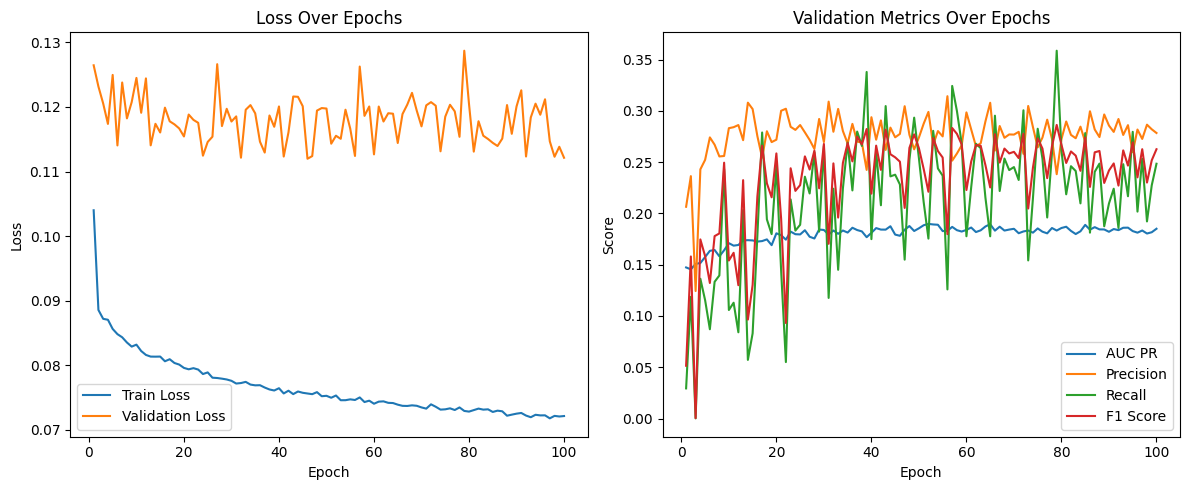

learning rate: 0.001


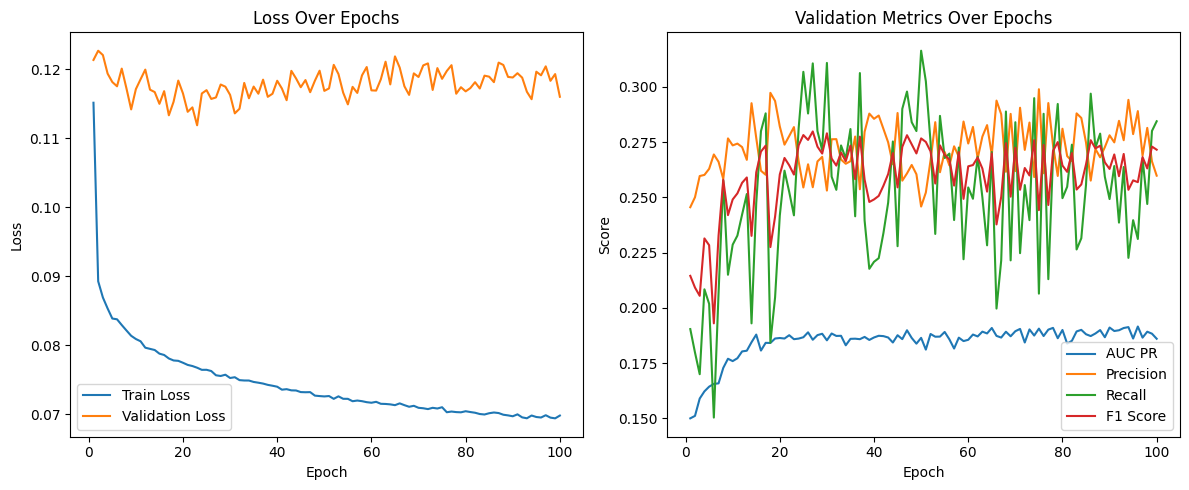

learning rate: 1e-05


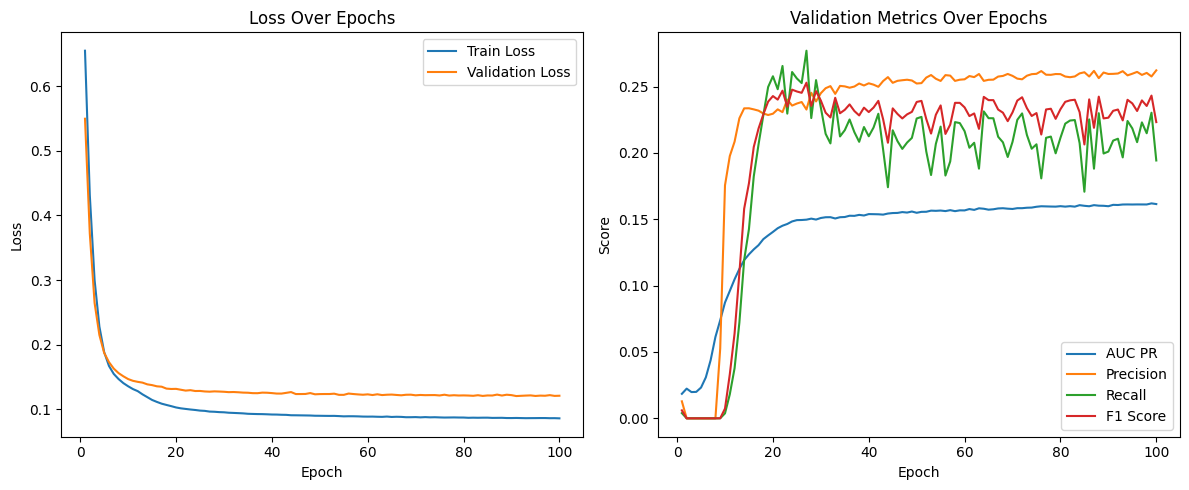

In [43]:
for i in range(len(lr_list)):
    print(f"learning rate: {lr_list[i]}")
    plot_training_history(history_withlr[i])

#### Test the model with different number of filters

Change the number of filters in the first convolutional block: 32

In [23]:
params_config = {
    'in_channels': 12,
    'out_channels': 1,
    'encoder_layers': [32, 16, 32],
    'decoder_layers': [32, 16],
    'encoder_pools': [1, 2, 2],
    'decoder_pools': [2, 2],
    'dropout': 0.1,
    'batch_norm': True
}

In [24]:
model2 = Autoencoder(**params_config)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2_trained, history, final_metrics = train_model(model2, train_loader, val_loader, lr=lr, pos_weight=pos_weight, num_epochs=num_epochs, device=device)


[Epoch 1/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 97.98it/s] 


New best model with AUC PR: 0.0960
Epoch [1/100] Train Loss: 0.2883 Val Loss: 0.1434 AUC PR: 0.0960 Precision: 0.2100 Recall: 0.0229 F1: 0.0414


[Epoch 2/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.16it/s]


New best model with AUC PR: 0.1406
Epoch [2/100] Train Loss: 0.1080 Val Loss: 0.1280 AUC PR: 0.1406 Precision: 0.2252 Recall: 0.2868 F1: 0.2523


[Epoch 3/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.25it/s]


New best model with AUC PR: 0.1498
Epoch [3/100] Train Loss: 0.0954 Val Loss: 0.1268 AUC PR: 0.1498 Precision: 0.2441 Recall: 0.2366 F1: 0.2403


[Epoch 4/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.16it/s]


New best model with AUC PR: 0.1510
Epoch [4/100] Train Loss: 0.0923 Val Loss: 0.1256 AUC PR: 0.1510 Precision: 0.2446 Recall: 0.2382 F1: 0.2413


[Epoch 5/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.73it/s]


New best model with AUC PR: 0.1547
Epoch [5/100] Train Loss: 0.0903 Val Loss: 0.1241 AUC PR: 0.1547 Precision: 0.2505 Recall: 0.2042 F1: 0.2250


[Epoch 6/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.55it/s]


New best model with AUC PR: 0.1557
Epoch [6/100] Train Loss: 0.0889 Val Loss: 0.1225 AUC PR: 0.1557 Precision: 0.2508 Recall: 0.2066 F1: 0.2265


[Epoch 7/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.65it/s]


New best model with AUC PR: 0.1573
Epoch [7/100] Train Loss: 0.0881 Val Loss: 0.1234 AUC PR: 0.1573 Precision: 0.2536 Recall: 0.1997 F1: 0.2235


[Epoch 8/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 99.92it/s]


New best model with AUC PR: 0.1582
Epoch [8/100] Train Loss: 0.0877 Val Loss: 0.1254 AUC PR: 0.1582 Precision: 0.2563 Recall: 0.1978 F1: 0.2233


[Epoch 9/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.56it/s]


Epoch [9/100] Train Loss: 0.0872 Val Loss: 0.1229 AUC PR: 0.1571 Precision: 0.2505 Recall: 0.2424 F1: 0.2464


[Epoch 10/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.20it/s]


New best model with AUC PR: 0.1591
Epoch [10/100] Train Loss: 0.0863 Val Loss: 0.1207 AUC PR: 0.1591 Precision: 0.2564 Recall: 0.2090 F1: 0.2303


[Epoch 11/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.38it/s]


Epoch [11/100] Train Loss: 0.0861 Val Loss: 0.1192 AUC PR: 0.1588 Precision: 0.2542 Recall: 0.2198 F1: 0.2358


[Epoch 12/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.60it/s]


New best model with AUC PR: 0.1619
Epoch [12/100] Train Loss: 0.0853 Val Loss: 0.1197 AUC PR: 0.1619 Precision: 0.2598 Recall: 0.1914 F1: 0.2204


[Epoch 13/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.67it/s]


Epoch [13/100] Train Loss: 0.0853 Val Loss: 0.1206 AUC PR: 0.1594 Precision: 0.2562 Recall: 0.2233 F1: 0.2386


[Epoch 14/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.36it/s]


Epoch [14/100] Train Loss: 0.0848 Val Loss: 0.1186 AUC PR: 0.1617 Precision: 0.2597 Recall: 0.2000 F1: 0.2260


[Epoch 15/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.65it/s]


Epoch [15/100] Train Loss: 0.0842 Val Loss: 0.1191 AUC PR: 0.1617 Precision: 0.2567 Recall: 0.2332 F1: 0.2444


[Epoch 16/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.75it/s]


New best model with AUC PR: 0.1628
Epoch [16/100] Train Loss: 0.0841 Val Loss: 0.1200 AUC PR: 0.1628 Precision: 0.2610 Recall: 0.2104 F1: 0.2330


[Epoch 17/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.66it/s]


New best model with AUC PR: 0.1653
Epoch [17/100] Train Loss: 0.0837 Val Loss: 0.1193 AUC PR: 0.1653 Precision: 0.2636 Recall: 0.1947 F1: 0.2240


[Epoch 18/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.15it/s]


Epoch [18/100] Train Loss: 0.0832 Val Loss: 0.1169 AUC PR: 0.1647 Precision: 0.2599 Recall: 0.2284 F1: 0.2431


[Epoch 19/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.37it/s]


New best model with AUC PR: 0.1667
Epoch [19/100] Train Loss: 0.0829 Val Loss: 0.1190 AUC PR: 0.1667 Precision: 0.2655 Recall: 0.1905 F1: 0.2218


[Epoch 20/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.88it/s]


New best model with AUC PR: 0.1670
Epoch [20/100] Train Loss: 0.0829 Val Loss: 0.1200 AUC PR: 0.1670 Precision: 0.2651 Recall: 0.1866 F1: 0.2190


[Epoch 21/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 98.72it/s]


Epoch [21/100] Train Loss: 0.0829 Val Loss: 0.1185 AUC PR: 0.1654 Precision: 0.2633 Recall: 0.2157 F1: 0.2371


[Epoch 22/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.62it/s]


Epoch [22/100] Train Loss: 0.0823 Val Loss: 0.1179 AUC PR: 0.1663 Precision: 0.2611 Recall: 0.2358 F1: 0.2478


[Epoch 23/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.34it/s]


New best model with AUC PR: 0.1687
Epoch [23/100] Train Loss: 0.0819 Val Loss: 0.1190 AUC PR: 0.1687 Precision: 0.2665 Recall: 0.2002 F1: 0.2286


[Epoch 24/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.58it/s]


New best model with AUC PR: 0.1692
Epoch [24/100] Train Loss: 0.0819 Val Loss: 0.1181 AUC PR: 0.1692 Precision: 0.2685 Recall: 0.1765 F1: 0.2130


[Epoch 25/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.02it/s]


Epoch [25/100] Train Loss: 0.0818 Val Loss: 0.1168 AUC PR: 0.1678 Precision: 0.2611 Recall: 0.2386 F1: 0.2493


[Epoch 26/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.43it/s]


New best model with AUC PR: 0.1698
Epoch [26/100] Train Loss: 0.0816 Val Loss: 0.1165 AUC PR: 0.1698 Precision: 0.2596 Recall: 0.2505 F1: 0.2549


[Epoch 27/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.99it/s]


Epoch [27/100] Train Loss: 0.0815 Val Loss: 0.1161 AUC PR: 0.1693 Precision: 0.2628 Recall: 0.2402 F1: 0.2510


[Epoch 28/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.59it/s]


New best model with AUC PR: 0.1711
Epoch [28/100] Train Loss: 0.0811 Val Loss: 0.1152 AUC PR: 0.1711 Precision: 0.2649 Recall: 0.2257 F1: 0.2438


[Epoch 29/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.99it/s]


Epoch [29/100] Train Loss: 0.0811 Val Loss: 0.1174 AUC PR: 0.1706 Precision: 0.2702 Recall: 0.2016 F1: 0.2309


[Epoch 30/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.48it/s]


New best model with AUC PR: 0.1731
Epoch [30/100] Train Loss: 0.0810 Val Loss: 0.1162 AUC PR: 0.1731 Precision: 0.2684 Recall: 0.2199 F1: 0.2417


[Epoch 31/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.41it/s]


Epoch [31/100] Train Loss: 0.0806 Val Loss: 0.1179 AUC PR: 0.1723 Precision: 0.2736 Recall: 0.1860 F1: 0.2214


[Epoch 32/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.62it/s]


New best model with AUC PR: 0.1741
Epoch [32/100] Train Loss: 0.0806 Val Loss: 0.1171 AUC PR: 0.1741 Precision: 0.2649 Recall: 0.2438 F1: 0.2539


[Epoch 33/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.26it/s]


New best model with AUC PR: 0.1757
Epoch [33/100] Train Loss: 0.0802 Val Loss: 0.1170 AUC PR: 0.1757 Precision: 0.2670 Recall: 0.2388 F1: 0.2521


[Epoch 34/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.51it/s]


New best model with AUC PR: 0.1768
Epoch [34/100] Train Loss: 0.0802 Val Loss: 0.1156 AUC PR: 0.1768 Precision: 0.2749 Recall: 0.2186 F1: 0.2435


[Epoch 35/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 101.36it/s]


Epoch [35/100] Train Loss: 0.0803 Val Loss: 0.1163 AUC PR: 0.1764 Precision: 0.2663 Recall: 0.2422 F1: 0.2537


[Epoch 36/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.19it/s]


New best model with AUC PR: 0.1769
Epoch [36/100] Train Loss: 0.0801 Val Loss: 0.1155 AUC PR: 0.1769 Precision: 0.2679 Recall: 0.2380 F1: 0.2520


[Epoch 37/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.75it/s]


New best model with AUC PR: 0.1778
Epoch [37/100] Train Loss: 0.0799 Val Loss: 0.1141 AUC PR: 0.1778 Precision: 0.2704 Recall: 0.2348 F1: 0.2514


[Epoch 38/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.45it/s]


New best model with AUC PR: 0.1782
Epoch [38/100] Train Loss: 0.0797 Val Loss: 0.1160 AUC PR: 0.1782 Precision: 0.2665 Recall: 0.2506 F1: 0.2583


[Epoch 39/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.42it/s]


Epoch [39/100] Train Loss: 0.0794 Val Loss: 0.1172 AUC PR: 0.1778 Precision: 0.2639 Recall: 0.2587 F1: 0.2613


[Epoch 40/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.11it/s]


New best model with AUC PR: 0.1784
Epoch [40/100] Train Loss: 0.0791 Val Loss: 0.1171 AUC PR: 0.1784 Precision: 0.2775 Recall: 0.2134 F1: 0.2412


[Epoch 41/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.71it/s]


Epoch [41/100] Train Loss: 0.0791 Val Loss: 0.1148 AUC PR: 0.1779 Precision: 0.2643 Recall: 0.2648 F1: 0.2645


[Epoch 42/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.13it/s]


Epoch [42/100] Train Loss: 0.0790 Val Loss: 0.1170 AUC PR: 0.1777 Precision: 0.2737 Recall: 0.2290 F1: 0.2494


[Epoch 43/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 101.89it/s]


New best model with AUC PR: 0.1794
Epoch [43/100] Train Loss: 0.0787 Val Loss: 0.1171 AUC PR: 0.1794 Precision: 0.2744 Recall: 0.2353 F1: 0.2534


[Epoch 44/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.10it/s]


New best model with AUC PR: 0.1814
Epoch [44/100] Train Loss: 0.0787 Val Loss: 0.1151 AUC PR: 0.1814 Precision: 0.2802 Recall: 0.2259 F1: 0.2501


[Epoch 45/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.81it/s]


Epoch [45/100] Train Loss: 0.0786 Val Loss: 0.1151 AUC PR: 0.1787 Precision: 0.2641 Recall: 0.2633 F1: 0.2637


[Epoch 46/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.38it/s]


Epoch [46/100] Train Loss: 0.0786 Val Loss: 0.1149 AUC PR: 0.1788 Precision: 0.2494 Recall: 0.3098 F1: 0.2763


[Epoch 47/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.51it/s]


New best model with AUC PR: 0.1821
Epoch [47/100] Train Loss: 0.0784 Val Loss: 0.1150 AUC PR: 0.1821 Precision: 0.2646 Recall: 0.2699 F1: 0.2672


[Epoch 48/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.16it/s]


New best model with AUC PR: 0.1827
Epoch [48/100] Train Loss: 0.0783 Val Loss: 0.1162 AUC PR: 0.1827 Precision: 0.2741 Recall: 0.2383 F1: 0.2550


[Epoch 49/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.61it/s]


Epoch [49/100] Train Loss: 0.0779 Val Loss: 0.1139 AUC PR: 0.1796 Precision: 0.2663 Recall: 0.2585 F1: 0.2624


[Epoch 50/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.02it/s]


Epoch [50/100] Train Loss: 0.0780 Val Loss: 0.1142 AUC PR: 0.1827 Precision: 0.2628 Recall: 0.2798 F1: 0.2710


[Epoch 51/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.05it/s]


Epoch [51/100] Train Loss: 0.0780 Val Loss: 0.1153 AUC PR: 0.1813 Precision: 0.2606 Recall: 0.2853 F1: 0.2724


[Epoch 52/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.40it/s]


New best model with AUC PR: 0.1837
Epoch [52/100] Train Loss: 0.0777 Val Loss: 0.1150 AUC PR: 0.1837 Precision: 0.2736 Recall: 0.2476 F1: 0.2599


[Epoch 53/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.85it/s]


New best model with AUC PR: 0.1846
Epoch [53/100] Train Loss: 0.0777 Val Loss: 0.1149 AUC PR: 0.1846 Precision: 0.2727 Recall: 0.2587 F1: 0.2655


[Epoch 54/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.10it/s]


New best model with AUC PR: 0.1848
Epoch [54/100] Train Loss: 0.0774 Val Loss: 0.1150 AUC PR: 0.1848 Precision: 0.2711 Recall: 0.2608 F1: 0.2659


[Epoch 55/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.33it/s]


Epoch [55/100] Train Loss: 0.0775 Val Loss: 0.1148 AUC PR: 0.1842 Precision: 0.2655 Recall: 0.2752 F1: 0.2703


[Epoch 56/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.71it/s]


New best model with AUC PR: 0.1854
Epoch [56/100] Train Loss: 0.0773 Val Loss: 0.1154 AUC PR: 0.1854 Precision: 0.2683 Recall: 0.2691 F1: 0.2687


[Epoch 57/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.81it/s]


Epoch [57/100] Train Loss: 0.0775 Val Loss: 0.1148 AUC PR: 0.1836 Precision: 0.2692 Recall: 0.2655 F1: 0.2673


[Epoch 58/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.02it/s]


New best model with AUC PR: 0.1863
Epoch [58/100] Train Loss: 0.0769 Val Loss: 0.1146 AUC PR: 0.1863 Precision: 0.2735 Recall: 0.2641 F1: 0.2687


[Epoch 59/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.33it/s]


New best model with AUC PR: 0.1866
Epoch [59/100] Train Loss: 0.0770 Val Loss: 0.1150 AUC PR: 0.1866 Precision: 0.2778 Recall: 0.2537 F1: 0.2652


[Epoch 60/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.59it/s]


Epoch [60/100] Train Loss: 0.0770 Val Loss: 0.1137 AUC PR: 0.1836 Precision: 0.2734 Recall: 0.2531 F1: 0.2629


[Epoch 61/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.57it/s]


New best model with AUC PR: 0.1884
Epoch [61/100] Train Loss: 0.0768 Val Loss: 0.1137 AUC PR: 0.1884 Precision: 0.2684 Recall: 0.2786 F1: 0.2734


[Epoch 62/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.63it/s]


Epoch [62/100] Train Loss: 0.0765 Val Loss: 0.1165 AUC PR: 0.1840 Precision: 0.2657 Recall: 0.2753 F1: 0.2704


[Epoch 63/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.31it/s]


Epoch [63/100] Train Loss: 0.0765 Val Loss: 0.1141 AUC PR: 0.1872 Precision: 0.2641 Recall: 0.2871 F1: 0.2751


[Epoch 64/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.93it/s]


Epoch [64/100] Train Loss: 0.0765 Val Loss: 0.1152 AUC PR: 0.1860 Precision: 0.2700 Recall: 0.2692 F1: 0.2696


[Epoch 65/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 100.61it/s]


New best model with AUC PR: 0.1884
Epoch [65/100] Train Loss: 0.0764 Val Loss: 0.1136 AUC PR: 0.1884 Precision: 0.2711 Recall: 0.2722 F1: 0.2716


[Epoch 66/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.87it/s]


Epoch [66/100] Train Loss: 0.0761 Val Loss: 0.1167 AUC PR: 0.1860 Precision: 0.2717 Recall: 0.2663 F1: 0.2690


[Epoch 67/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 101.09it/s]


Epoch [67/100] Train Loss: 0.0761 Val Loss: 0.1141 AUC PR: 0.1864 Precision: 0.2625 Recall: 0.2930 F1: 0.2770


[Epoch 68/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.09it/s]


Epoch [68/100] Train Loss: 0.0761 Val Loss: 0.1150 AUC PR: 0.1849 Precision: 0.2696 Recall: 0.2710 F1: 0.2703


[Epoch 69/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 98.66it/s]


Epoch [69/100] Train Loss: 0.0760 Val Loss: 0.1143 AUC PR: 0.1883 Precision: 0.2749 Recall: 0.2671 F1: 0.2709


[Epoch 70/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.48it/s]


Epoch [70/100] Train Loss: 0.0763 Val Loss: 0.1156 AUC PR: 0.1873 Precision: 0.2725 Recall: 0.2738 F1: 0.2731


[Epoch 71/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 100.60it/s]


Epoch [71/100] Train Loss: 0.0758 Val Loss: 0.1154 AUC PR: 0.1873 Precision: 0.2708 Recall: 0.2718 F1: 0.2713


[Epoch 72/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.57it/s]


Epoch [72/100] Train Loss: 0.0757 Val Loss: 0.1146 AUC PR: 0.1856 Precision: 0.2560 Recall: 0.3108 F1: 0.2808


[Epoch 73/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.25it/s]


Epoch [73/100] Train Loss: 0.0756 Val Loss: 0.1147 AUC PR: 0.1862 Precision: 0.2548 Recall: 0.3153 F1: 0.2818


[Epoch 77/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.49it/s]


Epoch [77/100] Train Loss: 0.0752 Val Loss: 0.1155 AUC PR: 0.1871 Precision: 0.2715 Recall: 0.2740 F1: 0.2727


[Epoch 78/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.15it/s]


Epoch [78/100] Train Loss: 0.0753 Val Loss: 0.1149 AUC PR: 0.1867 Precision: 0.2663 Recall: 0.2849 F1: 0.2753


[Epoch 79/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.73it/s]


Epoch [79/100] Train Loss: 0.0753 Val Loss: 0.1151 AUC PR: 0.1864 Precision: 0.2634 Recall: 0.2929 F1: 0.2773


[Epoch 80/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.39it/s]


Epoch [80/100] Train Loss: 0.0753 Val Loss: 0.1156 AUC PR: 0.1867 Precision: 0.2605 Recall: 0.3052 F1: 0.2811


[Epoch 81/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.34it/s]


New best model with AUC PR: 0.1902
Epoch [81/100] Train Loss: 0.0750 Val Loss: 0.1156 AUC PR: 0.1902 Precision: 0.2749 Recall: 0.2668 F1: 0.2708


[Epoch 82/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 102.89it/s]


Epoch [82/100] Train Loss: 0.0752 Val Loss: 0.1155 AUC PR: 0.1882 Precision: 0.2692 Recall: 0.2760 F1: 0.2726


[Epoch 83/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 106.13it/s]


Epoch [83/100] Train Loss: 0.0748 Val Loss: 0.1151 AUC PR: 0.1893 Precision: 0.2636 Recall: 0.2975 F1: 0.2795


[Epoch 84/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.94it/s]


Epoch [84/100] Train Loss: 0.0747 Val Loss: 0.1151 AUC PR: 0.1890 Precision: 0.2743 Recall: 0.2664 F1: 0.2703


[Epoch 85/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.30it/s]


Epoch [85/100] Train Loss: 0.0748 Val Loss: 0.1157 AUC PR: 0.1899 Precision: 0.2684 Recall: 0.2850 F1: 0.2765


[Epoch 86/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.34it/s]


Epoch [86/100] Train Loss: 0.0746 Val Loss: 0.1155 AUC PR: 0.1888 Precision: 0.2664 Recall: 0.2829 F1: 0.2744


[Epoch 87/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.89it/s]


Epoch [87/100] Train Loss: 0.0743 Val Loss: 0.1150 AUC PR: 0.1893 Precision: 0.2678 Recall: 0.2803 F1: 0.2739


[Epoch 88/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.92it/s]


Epoch [88/100] Train Loss: 0.0746 Val Loss: 0.1169 AUC PR: 0.1898 Precision: 0.2689 Recall: 0.2802 F1: 0.2744


[Epoch 89/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.05it/s]


Epoch [89/100] Train Loss: 0.0744 Val Loss: 0.1155 AUC PR: 0.1876 Precision: 0.2614 Recall: 0.2996 F1: 0.2792


[Epoch 90/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.04it/s]


Epoch [90/100] Train Loss: 0.0743 Val Loss: 0.1162 AUC PR: 0.1877 Precision: 0.2642 Recall: 0.2870 F1: 0.2752


[Epoch 91/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.24it/s]


Epoch [91/100] Train Loss: 0.0747 Val Loss: 0.1156 AUC PR: 0.1874 Precision: 0.2682 Recall: 0.2845 F1: 0.2761


[Epoch 92/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.12it/s]


Epoch [92/100] Train Loss: 0.0744 Val Loss: 0.1143 AUC PR: 0.1899 Precision: 0.2737 Recall: 0.2665 F1: 0.2701


[Epoch 93/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.38it/s]


New best model with AUC PR: 0.1905
Epoch [93/100] Train Loss: 0.0740 Val Loss: 0.1146 AUC PR: 0.1905 Precision: 0.2635 Recall: 0.3023 F1: 0.2816


[Epoch 94/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.86it/s]


Epoch [94/100] Train Loss: 0.0742 Val Loss: 0.1165 AUC PR: 0.1904 Precision: 0.2688 Recall: 0.2861 F1: 0.2772


[Epoch 95/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.64it/s]


New best model with AUC PR: 0.1905
Epoch [95/100] Train Loss: 0.0740 Val Loss: 0.1161 AUC PR: 0.1905 Precision: 0.2772 Recall: 0.2636 F1: 0.2702


[Epoch 96/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 101.28it/s]


Epoch [96/100] Train Loss: 0.0740 Val Loss: 0.1158 AUC PR: 0.1886 Precision: 0.2714 Recall: 0.2685 F1: 0.2699


[Epoch 97/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 103.96it/s]


Epoch [97/100] Train Loss: 0.0742 Val Loss: 0.1158 AUC PR: 0.1895 Precision: 0.2665 Recall: 0.2845 F1: 0.2752


[Epoch 98/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.37it/s]


New best model with AUC PR: 0.1927
Epoch [98/100] Train Loss: 0.0738 Val Loss: 0.1160 AUC PR: 0.1927 Precision: 0.2693 Recall: 0.2897 F1: 0.2791


[Epoch 99/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 105.62it/s]


Epoch [99/100] Train Loss: 0.0740 Val Loss: 0.1163 AUC PR: 0.1892 Precision: 0.2744 Recall: 0.2630 F1: 0.2686


[Epoch 100/100] Validation: 100%|██████████| 59/59 [00:00<00:00, 104.91it/s]


Epoch [100/100] Train Loss: 0.0738 Val Loss: 0.1167 AUC PR: 0.1898 Precision: 0.2807 Recall: 0.2472 F1: 0.2629

Final Model Performance:
AUC PR: 0.1898
Precision: 0.2807
Recall: 0.2472
F1 Score: 0.2629


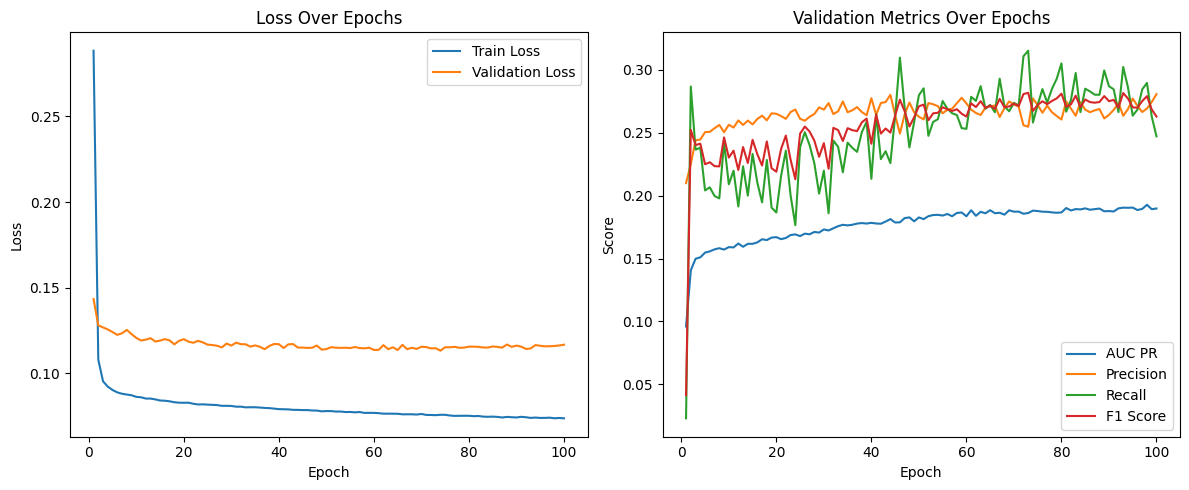

In [26]:
plot_training_history(history)

In [35]:
save_model(model2_trained, 'model_init32_state.pth')

Model state_dict saved to models/model_init32_state.pth


In [39]:
model = Autoencoder(**params_config)
model.load_state_dict(torch.load('models/model_init32_state.pth', weights_only=True))
model.to(device)
model.eval()  # Set to evaluation mode (important for inference)

Autoencoder(
  (input_conv): Sequential(
    (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout2d(p=0.1, inplace=False)
  )
  (input_shortcut): Sequential(
    (0): Conv2d(12, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (encoder_blocks): ModuleList(
    (0): ResBlock3(
      (net): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Dropout2d(p=0.1, inplace=False)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(32

In [40]:
metrics = evaluate_model_metrics(model, test_loader, threshold=0.5, device=device)
print("Test Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


Test Metrics:
auc_pr: 0.2451
precision: 0.3373
recall: 0.3297
f1_score: 0.3335
